In [1]:
import os
import time
import numpy as np
import pandas as pd
import ta  # pip install ta
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import math

In [12]:
# =============================================================================
# Part 1: Data Processing - Reprocess CSV Files up to April 11, 2025
# =============================================================================

# Set the desired date range (dates in DD/MM/YYYY format)
start_date_str = "02/01/2018"  # Start date remains the same
end_date_str   = "28/02/2025"  # Update end date to April 11, 2025
start_date_filter = pd.to_datetime(start_date_str, dayfirst=True)
end_date_filter   = pd.to_datetime(end_date_str, dayfirst=True)

raw_data_dir = "./data2"           # Folder with raw CSV files (e.g., AAPL.csv, SPY.csv)
filtered_data_dir = "./filtered_data_lstmgru2"
os.makedirs(filtered_data_dir, exist_ok=True)


In [13]:
def calculate_tema(series, window):
    """
    Calculate the Triple Exponential Moving Average (TEMA).
    TEMA = 3*EMA1 - 3*EMA2 + EMA3, where EMA1 = EMA(series, window), etc.
    """
    ema1 = ta.trend.EMAIndicator(close=series, window=window, fillna=False).ema_indicator()
    ema2 = ta.trend.EMAIndicator(close=ema1, window=window, fillna=False).ema_indicator()
    ema3 = ta.trend.EMAIndicator(close=ema2, window=window, fillna=False).ema_indicator()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema

def process_csv(file_path, filename):
    try:
        # For SPY, assume date format is DD-MM-YYYY; for others, YYYY-MM-DD
        if filename.upper() == "SPY.CSV":
            df = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=True)
        else:
            df = pd.read_csv(file_path, parse_dates=["Date"], dayfirst=False)
        df.dropna(subset=["Date"], inplace=True)
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True).dt.tz_localize(None)
        
        required_columns = ["Close", "High", "Low", "Open", "Volume"]
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"Warning: {filename} is missing columns: {missing_columns}")
            return None
        
        print(f"{filename} - Date Range: {df['Date'].min()} to {df['Date'].max()}")
        # Filter rows within the desired date range
        df_filtered = df[(df["Date"] >= start_date_filter) & (df["Date"] <= end_date_filter)].copy()
        if df_filtered.empty:
            print(f"Warning: {filename} has no data within the specified date range.")
            return None
        
        # Retain only essential columns
        df_filtered = df_filtered[["Date", "Open", "High", "Low", "Close", "Volume"]]
        
        # Calculate Standard Technical Indicators for various windows
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"SMA_{window}"] = ta.trend.SMAIndicator(close=df_filtered["Close"], window=window, fillna=False).sma_indicator()
            df_filtered[f"EMA_{window}"] = ta.trend.EMAIndicator(close=df_filtered["Close"], window=window, fillna=False).ema_indicator()
            df_filtered[f"TEMA_{window}"] = calculate_tema(df_filtered["Close"], window)
        
        # Bollinger Bands (20-day, 2 std dev)
        bb_indicator = ta.volatility.BollingerBands(close=df_filtered["Close"], window=20, window_dev=2, fillna=False)
        df_filtered["BB_Hband"] = bb_indicator.bollinger_hband()
        df_filtered["BB_Mband"] = bb_indicator.bollinger_mavg()
        df_filtered["BB_Lband"] = bb_indicator.bollinger_lband()
        
        # RSI (14-day)
        df_filtered["RSI_14"] = ta.momentum.RSIIndicator(close=df_filtered["Close"], window=14, fillna=False).rsi()
        
        # MACD - default parameters: fast=12, slow=26, signal=9
        macd_indicator = ta.trend.MACD(close=df_filtered["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=False)
        df_filtered["MACD"] = macd_indicator.macd()
        df_filtered["MACD_Signal"] = macd_indicator.macd_signal()
        df_filtered["MACD_Hist"] = macd_indicator.macd_diff()
        
        # Derived feature: Mean_HL as the average of High and Low
        df_filtered["Mean_HL"] = (df_filtered["High"] + df_filtered["Low"]) / 2.0
        
        # Extra Relative & Trend-based Indicators
        df_filtered["RMom_14"] = df_filtered["Close"] / df_filtered["Close"].shift(14)
        for window in [14, 26, 50, 100, 200]:
            df_filtered[f"MomTEMA_{window}_ofs1"] = df_filtered[f"TEMA_{window}"] / df_filtered[f"TEMA_{window}"].shift(1)
            df_filtered[f"RCTEMA_{window}"] = df_filtered["Close"] / df_filtered[f"TEMA_{window}"]
            df_filtered[f"MomEMA_{window}_ofs1"] = df_filtered[f"EMA_{window}"] / df_filtered[f"EMA_{window}"].shift(1)
        
        # Ratio indicators (example: fast vs. slow windows)
        df_filtered["RTEMA_TEMA_14_50"] = df_filtered["TEMA_14"] / df_filtered["TEMA_50"]
        df_filtered["REMA_EMA_14_50"] = df_filtered["EMA_14"] / df_filtered["EMA_50"]
        df_filtered["RSMA_SMA_14_50"] = df_filtered["SMA_14"] / df_filtered["SMA_50"]
        
        # Relative Volume to 20-day SMA
        df_filtered["RVolSMA_20"] = df_filtered["Volume"] / df_filtered["Volume"].rolling(window=20).mean()
        
        # Remove rows with NaN values from indicator calculations
        df_filtered.dropna(inplace=True)
        
        # Convert dates to ISO format (YYYY-MM-DD)
        df_filtered["Date"] = df_filtered["Date"].dt.strftime("%Y-%m-%d")
        return df_filtered
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None


In [6]:
# Process and save each CSV file with the new date range
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(raw_data_dir, filename)
        processed_df = process_csv(file_path, filename)
        if processed_df is not None:
            output_path = os.path.join(filtered_data_dir, filename)
            processed_df.to_csv(output_path, index=False)
            print(f"Processed {filename} and saved to {output_path}")

print("CSV processing complete.")

AAPL.csv - Date Range: 1980-12-12 05:00:00 to 2025-04-11 04:00:00
Processed AAPL.csv and saved to ./filtered_data_lstmgru2\AAPL.csv
ABBV.csv - Date Range: 2013-01-02 05:00:00 to 2025-04-11 04:00:00
Processed ABBV.csv and saved to ./filtered_data_lstmgru2\ABBV.csv
ADBE.csv - Date Range: 1986-08-13 04:00:00 to 2025-04-11 04:00:00
Processed ADBE.csv and saved to ./filtered_data_lstmgru2\ADBE.csv
AMD.csv - Date Range: 1980-03-17 05:00:00 to 2025-04-11 04:00:00
Processed AMD.csv and saved to ./filtered_data_lstmgru2\AMD.csv
AMT.csv - Date Range: 1998-02-27 05:00:00 to 2025-04-11 04:00:00
Processed AMT.csv and saved to ./filtered_data_lstmgru2\AMT.csv
AMZN.csv - Date Range: 1997-05-15 04:00:00 to 2025-04-11 04:00:00
Processed AMZN.csv and saved to ./filtered_data_lstmgru2\AMZN.csv
BA.csv - Date Range: 1962-01-02 05:00:00 to 2025-04-11 04:00:00
Processed BA.csv and saved to ./filtered_data_lstmgru2\BA.csv
BAC.csv - Date Range: 1973-02-21 05:00:00 to 2025-04-11 04:00:00
Processed BAC.csv and s

In [14]:
# =============================================================================
# Part 2: Feature Engineering and Sequence Preparation for Testing
# =============================================================================

def load_csv_data(filepath):
    """Load a CSV file and ensure the Date column is in proper datetime format."""
    df = pd.read_csv(filepath)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.sort_values("Date", inplace=True)
    return df

def get_model_features(df):
    """
    Build a DataFrame with a fixed set of features.
    If a feature is missing, fill it with 0.
    """
    desired_features = [
        "Open", "High", "Low", "Close", "Volume",
        "RSI_14",
        "SMA_14", "SMA_26", "SMA_50", "SMA_100", "SMA_200",
        "EMA_14", "EMA_26", "EMA_50", "EMA_100", "EMA_200",
        "BB_Hband", "BB_Mband", "BB_Lband",
        "Mean_HL", "MACD", "MACD_Signal", "MACD_Hist",
        "RMom_14", "MomTEMA_14_ofs1", "MomTEMA_26_ofs1", "MomTEMA_50_ofs1", "MomTEMA_100_ofs1", "MomTEMA_200_ofs1",
        "RCTEMA_14", "RCTEMA_26", "RCTEMA_50", "RCTEMA_100", "RCTEMA_200",
        "MomEMA_14_ofs1", "MomEMA_26_ofs1", "MomEMA_50_ofs1", "MomEMA_100_ofs1", "MomEMA_200_ofs1",
        "RTEMA_TEMA_14_50", "REMA_EMA_14_50", "RSMA_SMA_14_50",
        "RVolSMA_20"
    ]
    for col in desired_features:
        if col not in df.columns:
            df[col] = 0.0
    return df[["Date"] + desired_features].copy()

sequence_length = 20

def prepare_sequences(df, seq_length):
    """
    Generate sliding-window sequences from the DataFrame.
    Each sequence has shape (seq_length, num_features) and the target is the next day's Close price.
    Returns X (features), y (target), and seq_dates (target dates).
    """
    dates = df["Date"].values
    df_features = df.drop(columns=["Date"])
    data_array = df_features.values
    X, y, seq_dates = [], [], []
    target_index = df_features.columns.get_loc("Close")
    for i in range(seq_length, len(data_array)):
        X.append(data_array[i-seq_length:i])
        y.append(data_array[i, target_index])
        seq_dates.append(dates[i])
    seq_dates = np.array(seq_dates, dtype='datetime64[ns]')
    return np.array(X), np.array(y), seq_dates

In [15]:
# Build sequences from all processed CSV files
X_list, y_list, dates_list, ticker_list = [], [], [], []
all_tickers = []

for filename in os.listdir(filtered_data_dir):
    if filename.endswith(".csv"):
        ticker = filename.split(".csv")[0]
        all_tickers.append(ticker)
        filepath = os.path.join(filtered_data_dir, filename)
        df_raw = load_csv_data(filepath)
        df_feat = get_model_features(df_raw)
        if len(df_feat) > sequence_length:
            X, y, seq_dates = prepare_sequences(df_feat, sequence_length)
            X_list.append(X)
            y_list.append(y)
            dates_list.append(seq_dates)
            ticker_list.extend([ticker] * len(y))

X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
dates_all = np.concatenate(dates_list, axis=0)
num_features = X_all.shape[2]

# Fit a global RobustScaler on the complete sequence data and scale each sequence.
scaler = RobustScaler()
all_data = X_all.reshape(-1, num_features)
scaler.fit(all_data)
X_all_scaled = np.array([scaler.transform(seq) for seq in X_all])


In [16]:
# =============================================================================
# Part 3: Filter for the New Test Data (Target Dates After February 28, 2025)
# =============================================================================

# Define the cutoff date for new test data (target dates after 28 Feb 2025)
new_data_split_date = np.datetime64("2024-02-28")

# Create a boolean mask based on the target dates
mask_new = dates_all > new_data_split_date
X_new = X_all_scaled[mask_new]
y_new = y_all[mask_new]
dates_new = dates_all[mask_new]

print("New data sequences (target dates > 2025-02-28):", X_new.shape[0])

New data sequences (target dates > 2025-02-28): 8960


In [17]:
# Enable unsafe deserialization to allow Lambda layer loading
import tensorflow as tf
tf.keras.config.enable_unsafe_deserialization()

# Load the pre-trained LSTM-GRU model
model = load_model("trained_model_lstmgru.keras")

# Generate predictions for the new sequences
y_new_pred = model.predict(X_new).flatten()

# Compute regression metrics
mae_new = mean_absolute_error(y_new, y_new_pred)
mse_new = mean_squared_error(y_new, y_new_pred)
r2_new = r2_score(y_new, y_new_pred)
max_err_new = max_error(y_new, y_new_pred)
rmse_new = math.sqrt(mse_new)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

mape_new = mean_absolute_percentage_error(y_new, y_new_pred)

print("Performance on New Data (After Feb 28, 2025):")
print(f"  MAE: {mae_new:.4f}")
print(f"  MSE: {mse_new:.4f}")
print(f"  RMSE: {rmse_new:.4f}")
print(f"  R²: {r2_new:.4f}")
print(f"  Max Error: {max_err_new:.4f}")
print(f"  MAPE: {mape_new:.2f}%")


280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step
Performance on New Data (After Feb 28, 2025):
  MAE: 10.7971
  MSE: 254.2949
  RMSE: 15.9466
  R²: 0.9927
  Max Error: 145.9899
  MAPE: 4.79%


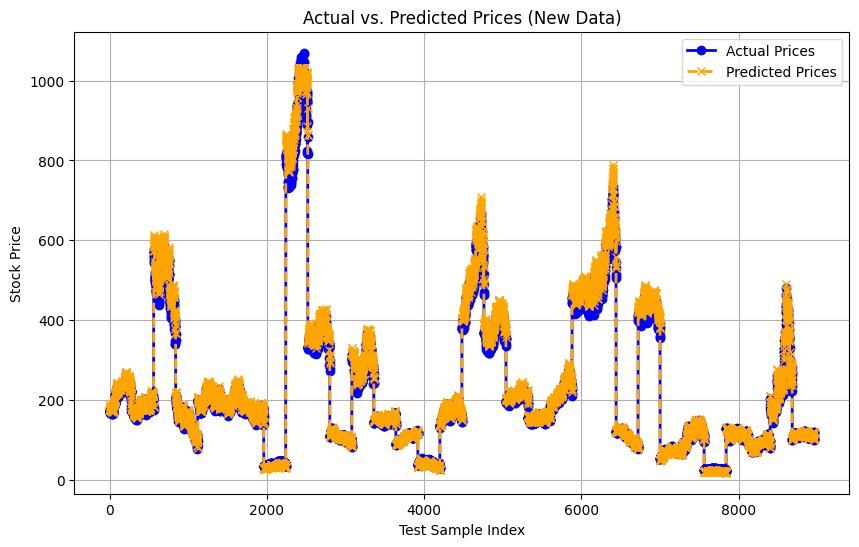

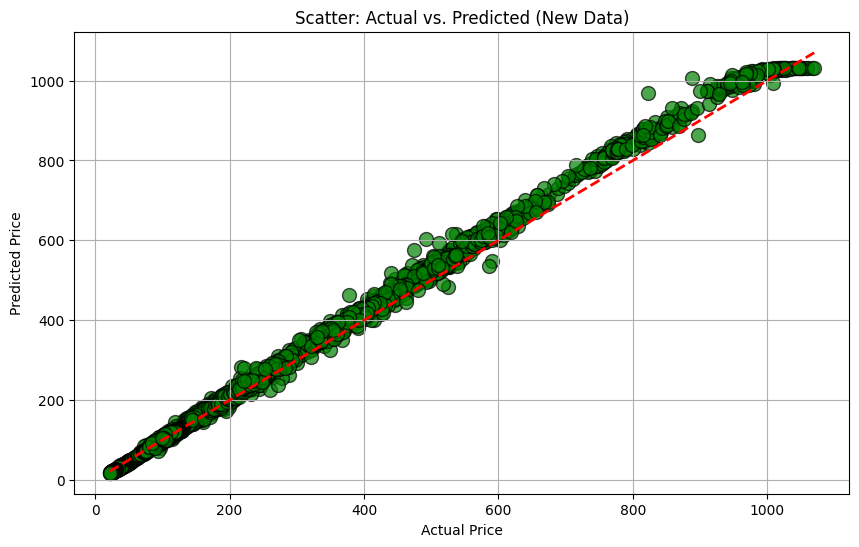

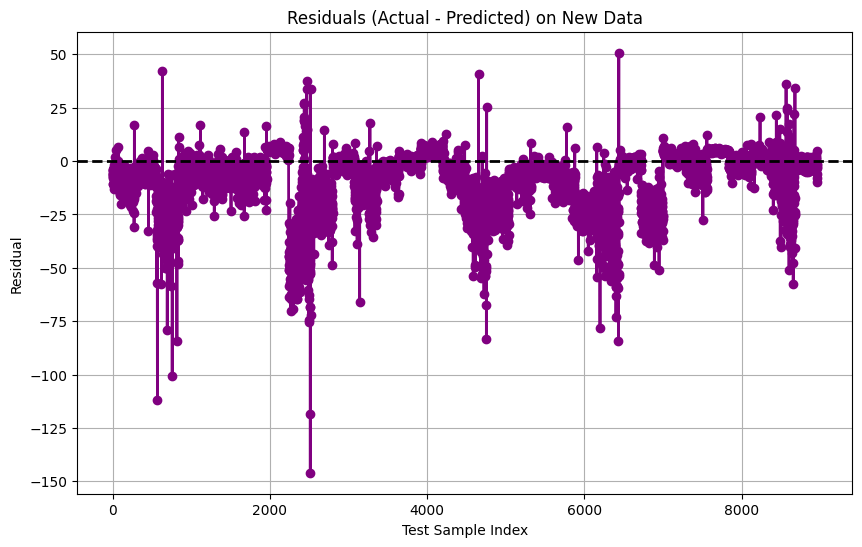

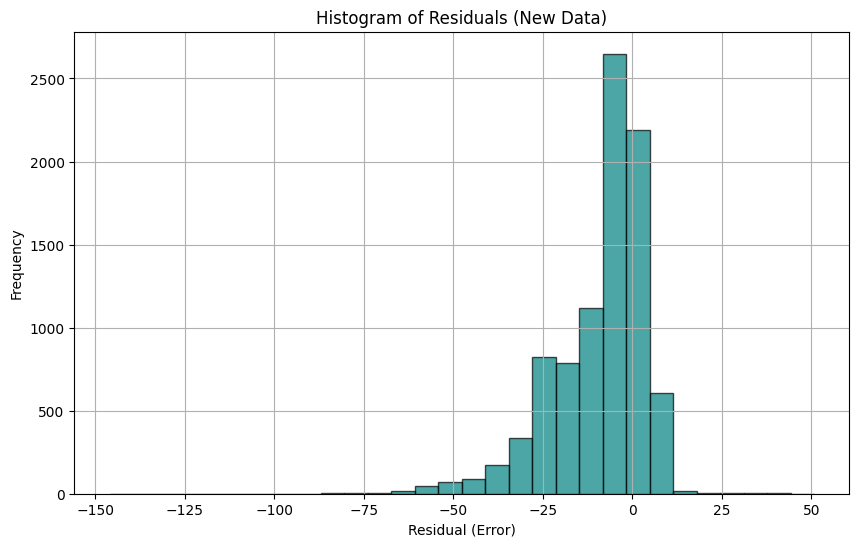

In [18]:
# =============================================================================
# Part 5: Visualization (Optional)
# =============================================================================

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(y_new, label="Actual Prices", color="blue", marker="o", linestyle="-", linewidth=2)
plt.plot(y_new_pred, label="Predicted Prices", color="orange", marker="x", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted Prices (New Data)")
plt.xlabel("Test Sample Index")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_new, y_new_pred, color="green", alpha=0.7, edgecolor="black", s=100)
plt.plot([min(y_new), max(y_new)], [min(y_new), max(y_new)], "r--", linewidth=2)
plt.title("Scatter: Actual vs. Predicted (New Data)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()

# Residual Plot: Actual minus Predicted
residuals = y_new - y_new_pred
plt.figure(figsize=(10, 6))
plt.plot(residuals, color="purple", marker="o", linestyle="-", linewidth=2)
plt.axhline(0, color="black", linestyle="--", linewidth=2)
plt.title("Residuals (Actual - Predicted) on New Data")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color="teal", edgecolor="black", alpha=0.7)
plt.title("Histogram of Residuals (New Data)")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [19]:
print(y_new_pred)

[187.097    186.26662  185.05936  ... 103.81459  101.134544 106.12369 ]


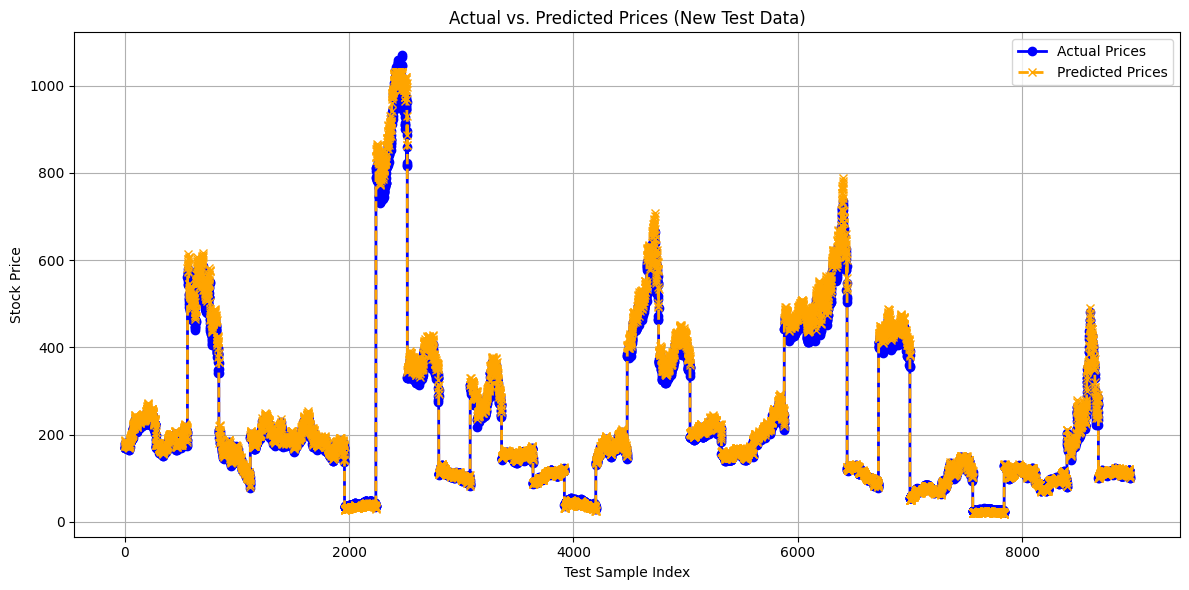

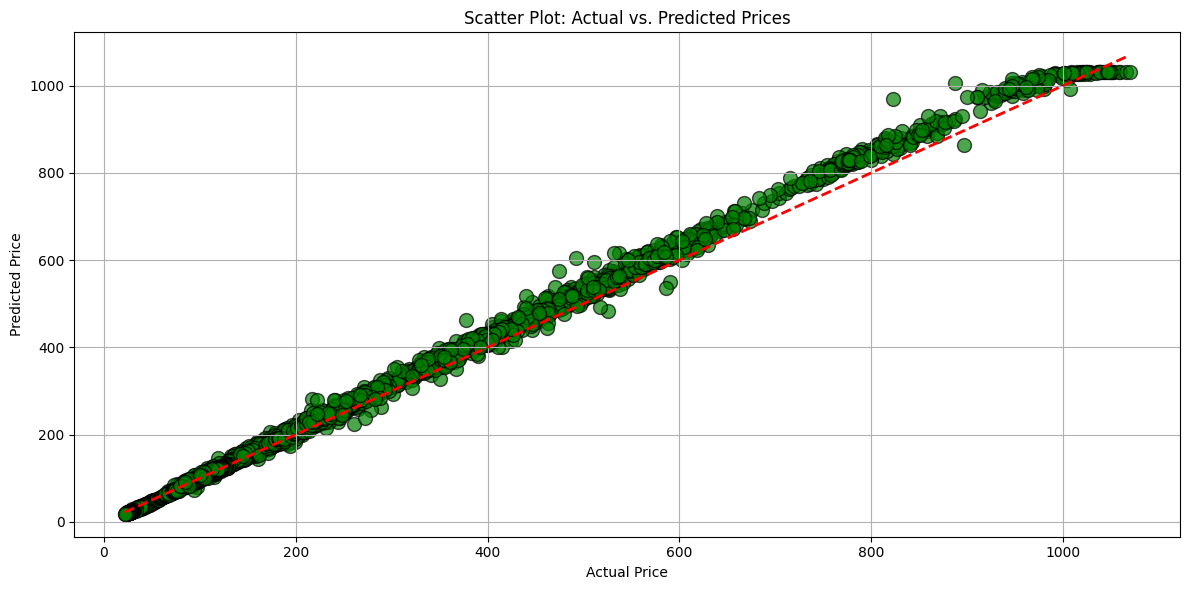

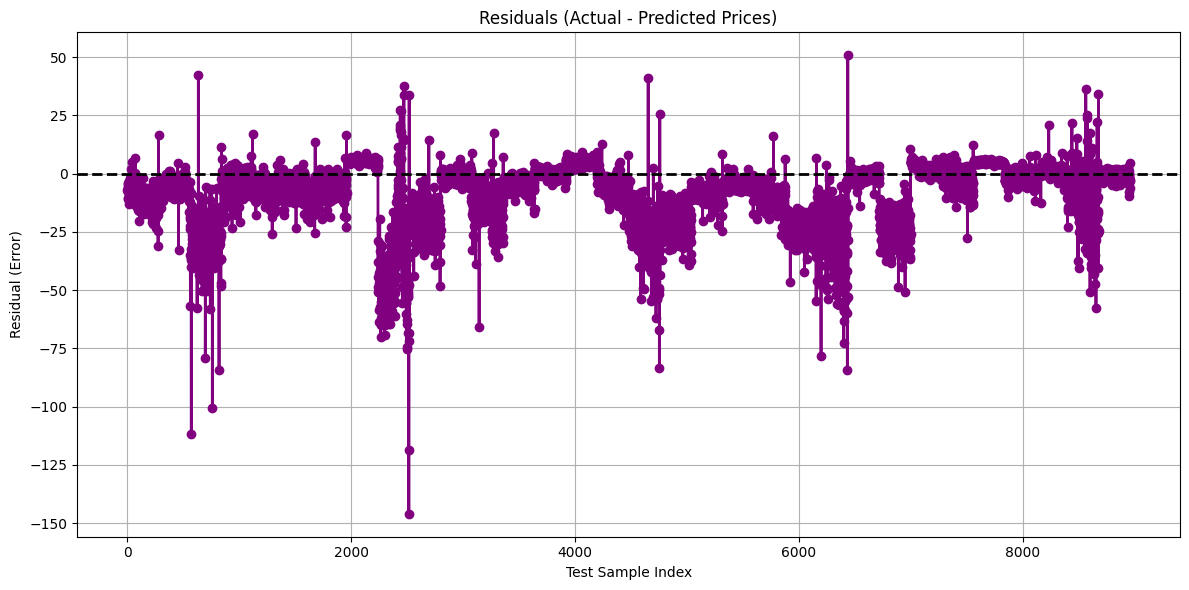

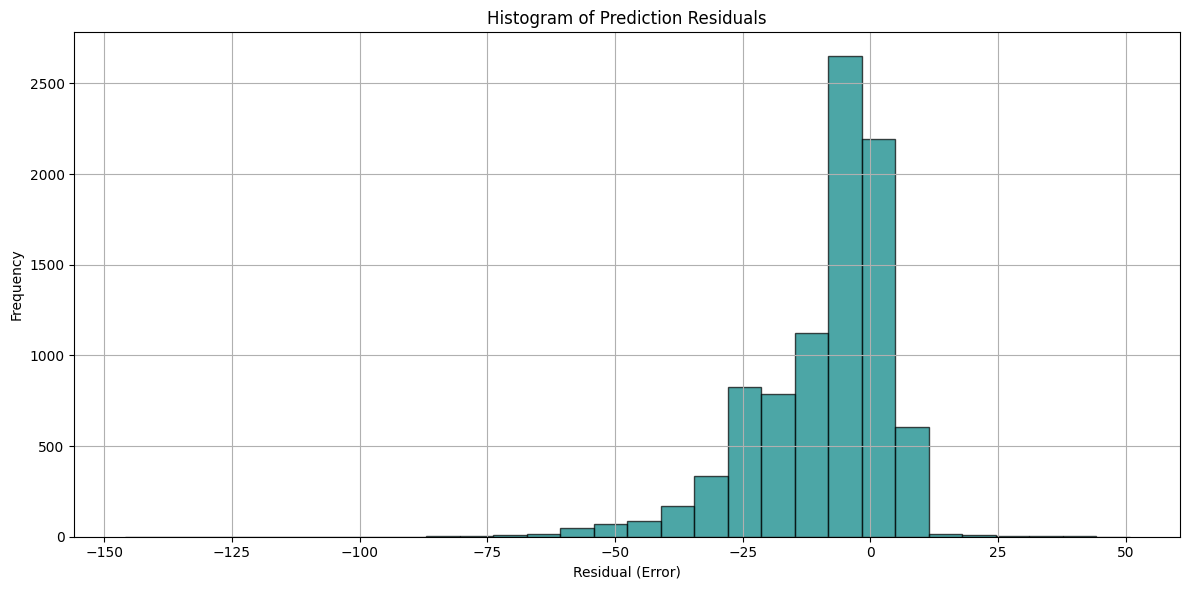

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Line Plot: Actual vs. Predicted Prices ---
plt.figure(figsize=(12, 6))
plt.plot(y_new, label="Actual Prices", color="blue", marker="o", linestyle="-", linewidth=2)
plt.plot(y_new_pred, label="Predicted Prices", color="orange", marker="x", linestyle="--", linewidth=2)
plt.title("Actual vs. Predicted Prices (New Test Data)")
plt.xlabel("Test Sample Index")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Scatter Plot: Actual vs. Predicted Prices ---
plt.figure(figsize=(12, 6))
plt.scatter(y_new, y_new_pred, color="green", alpha=0.7, edgecolor="black", s=100)
plt.plot([min(y_new), max(y_new)], [min(y_new), max(y_new)], "r--", linewidth=2)
plt.title("Scatter Plot: Actual vs. Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Residual Plot: Actual Minus Predicted ---
residuals = y_new - y_new_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals, color="purple", marker="o", linestyle="-", linewidth=2)
plt.axhline(0, color="black", linestyle="--", linewidth=2)
plt.title("Residuals (Actual - Predicted Prices)")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (Error)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4. Histogram of Residuals ---
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color="teal", edgecolor="black", alpha=0.7)
plt.title("Histogram of Prediction Residuals")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


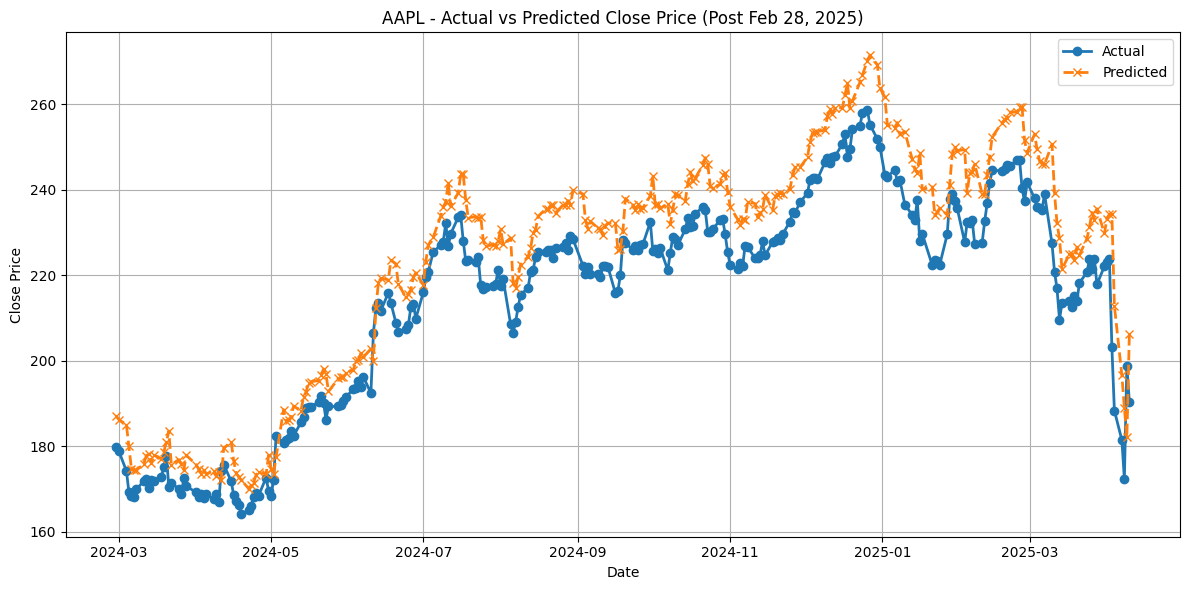

AAPL - MAE: 9.44, RMSE: 10.38


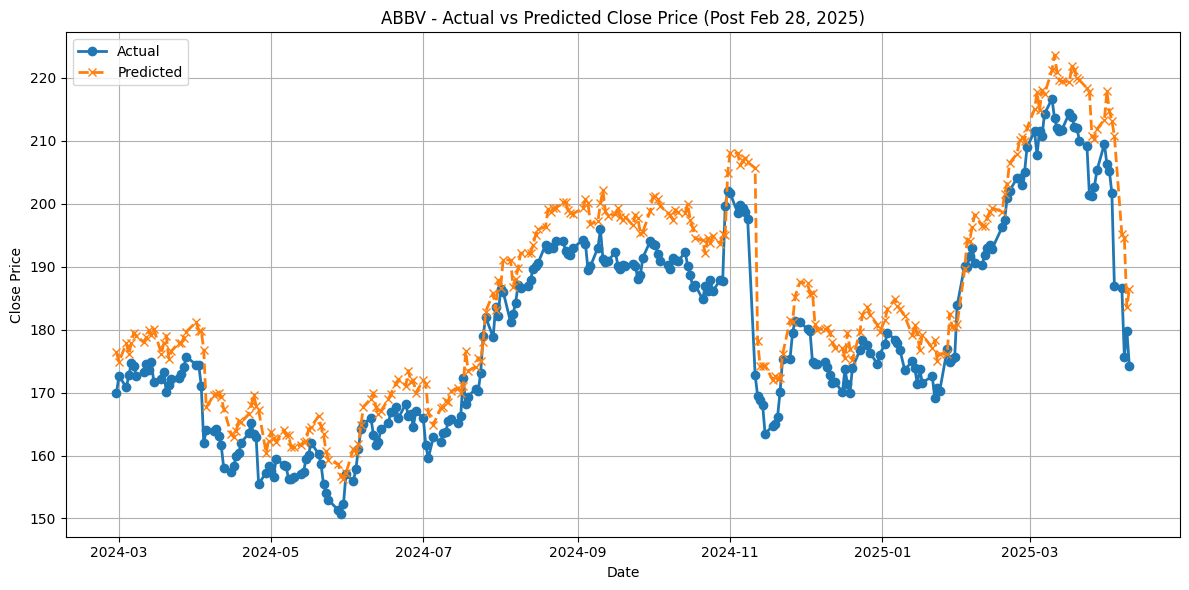

ABBV - MAE: 5.99, RMSE: 6.83


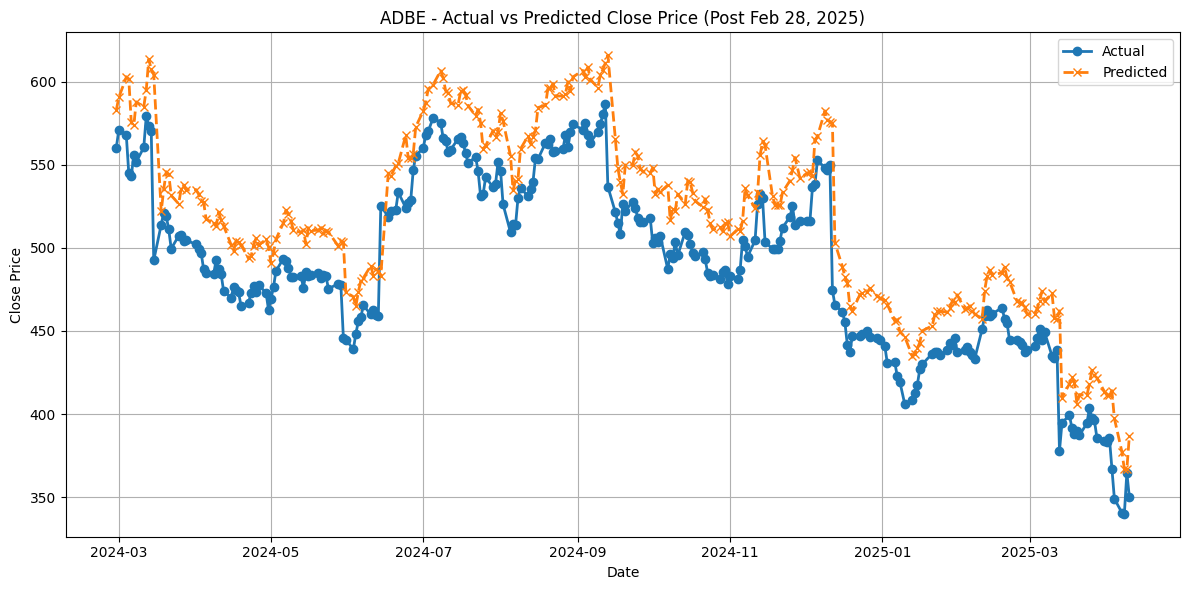

ADBE - MAE: 28.74, RMSE: 31.01


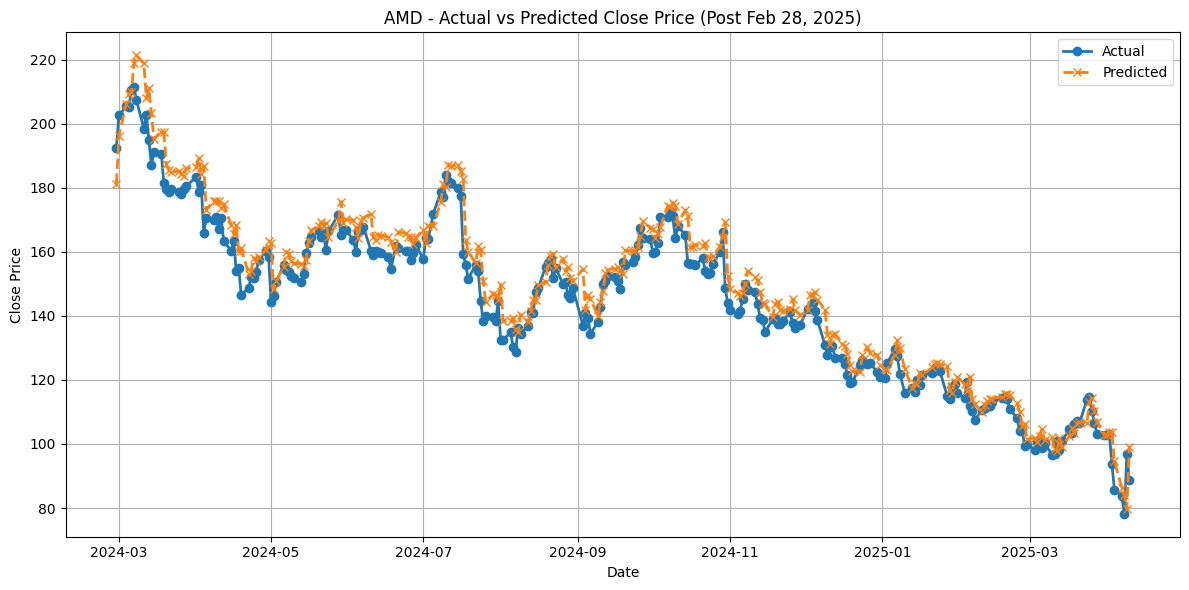

AMD - MAE: 4.99, RMSE: 6.47


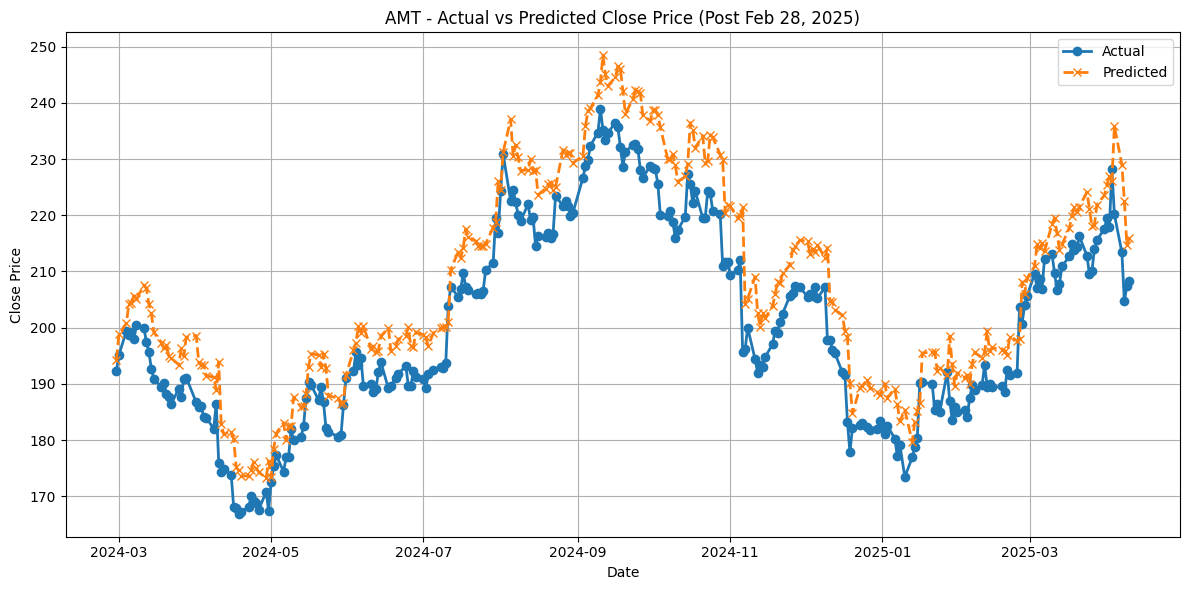

AMT - MAE: 7.48, RMSE: 8.27


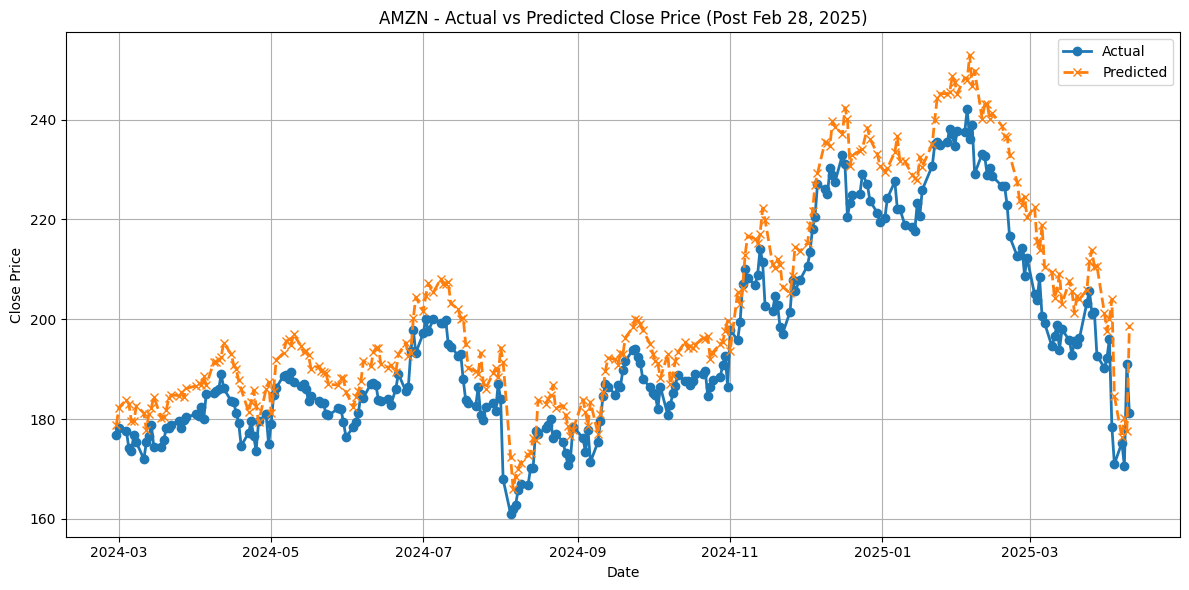

AMZN - MAE: 7.60, RMSE: 8.60


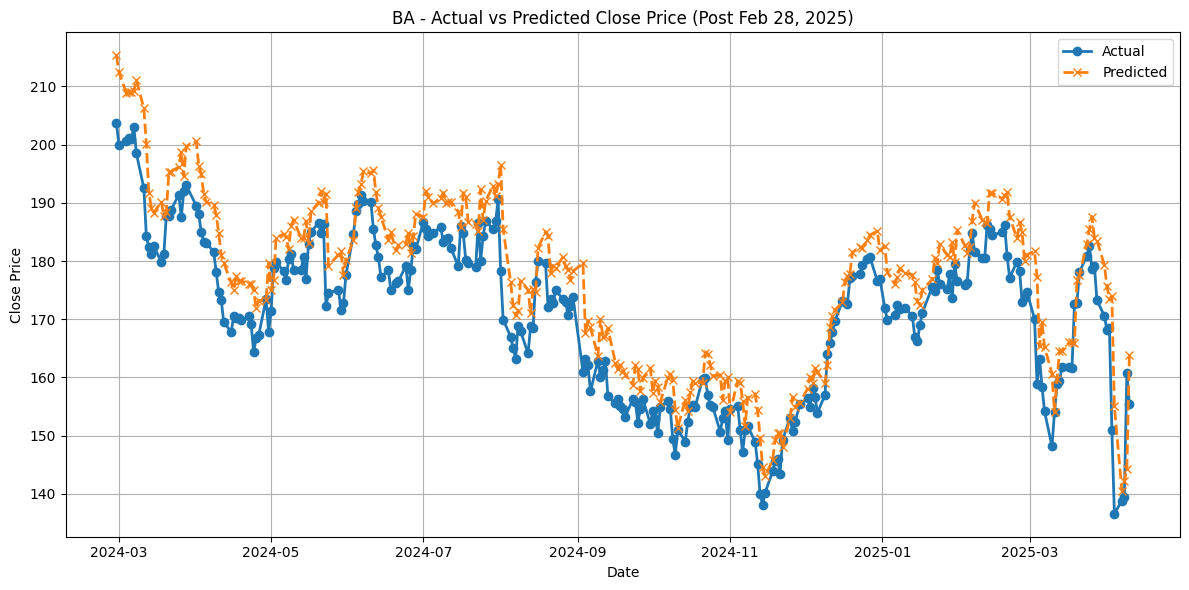

BA - MAE: 6.19, RMSE: 7.29


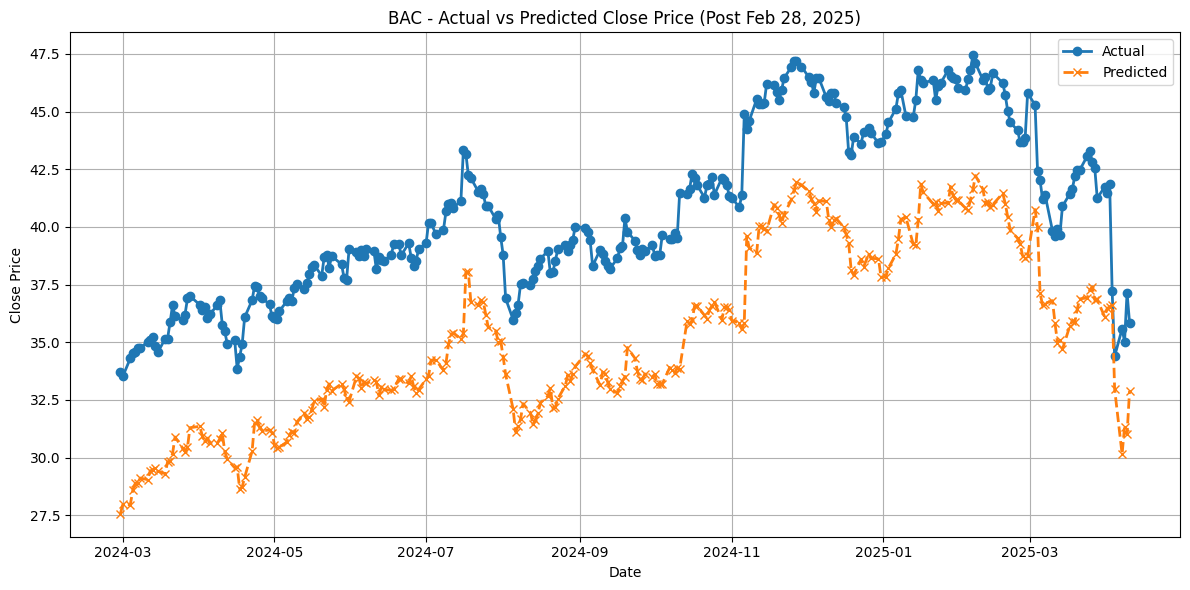

BAC - MAE: 5.46, RMSE: 5.52


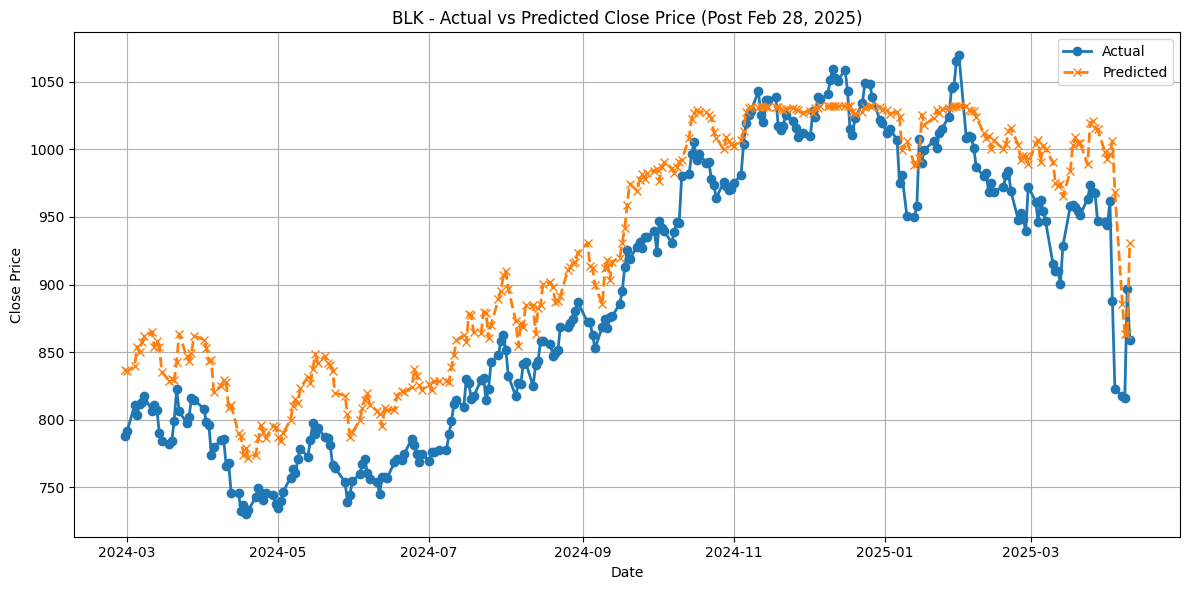

BLK - MAE: 38.91, RMSE: 43.01


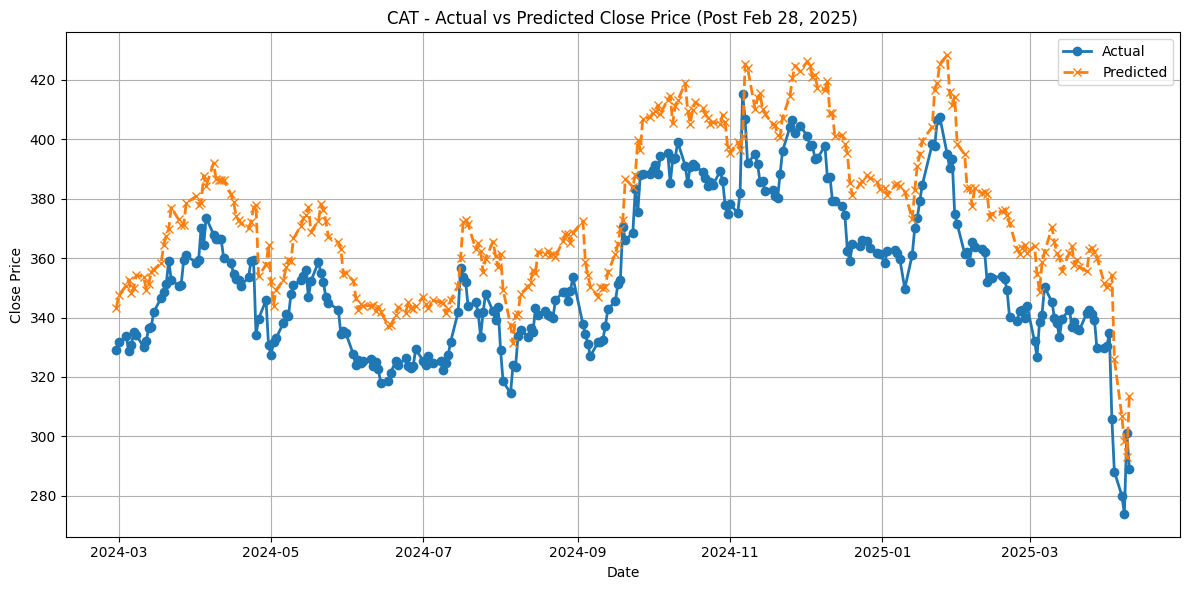

CAT - MAE: 20.14, RMSE: 21.10


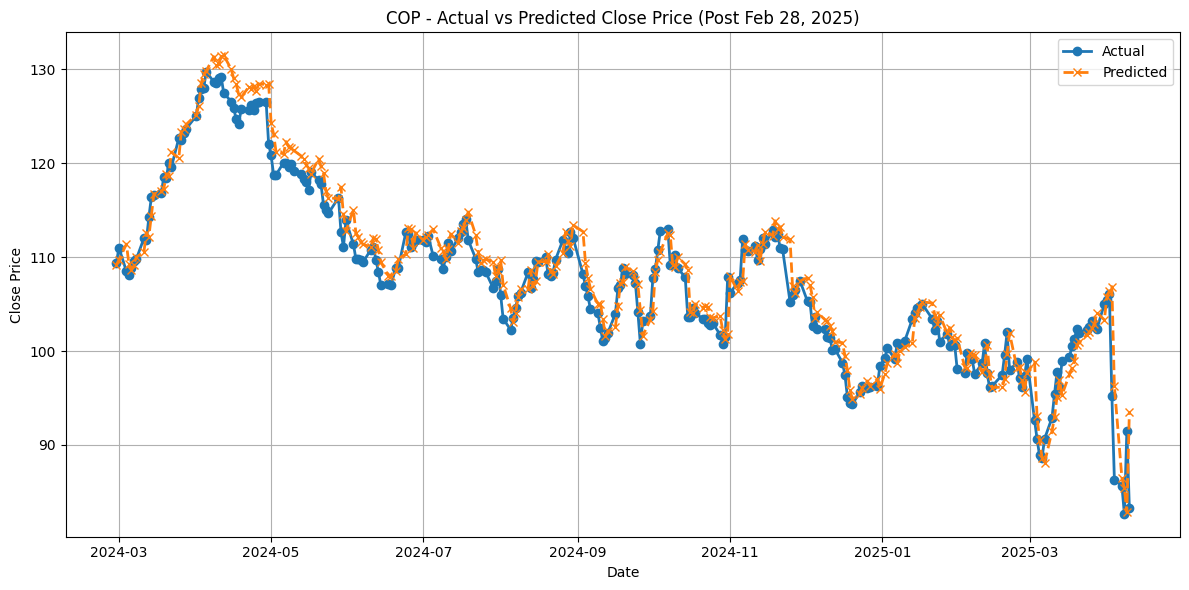

COP - MAE: 1.66, RMSE: 2.29


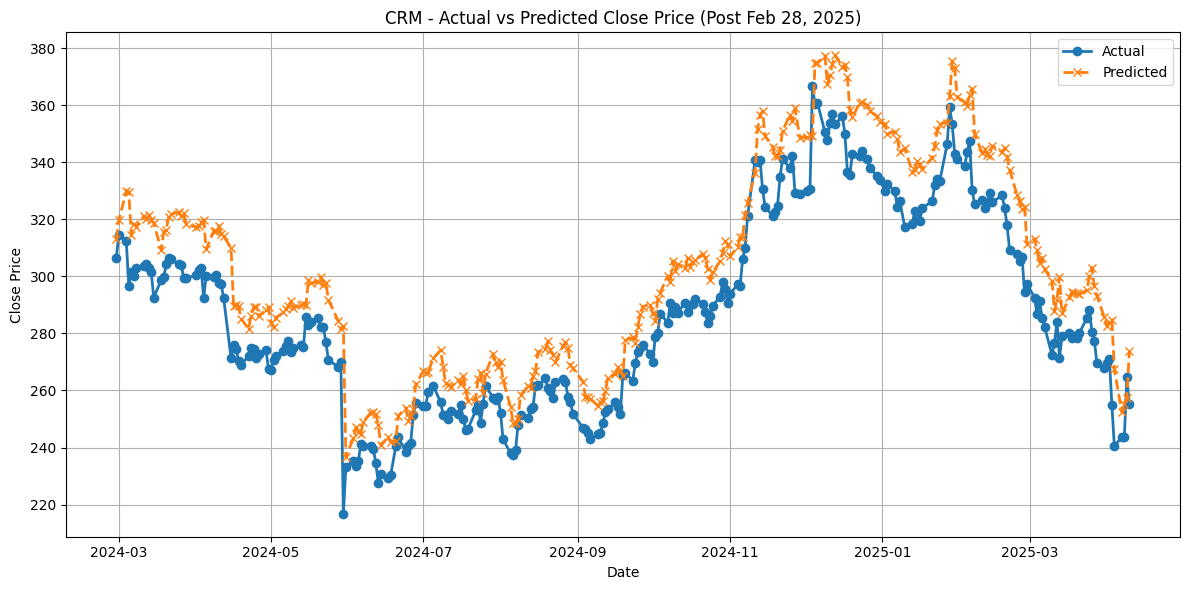

CRM - MAE: 15.41, RMSE: 16.87


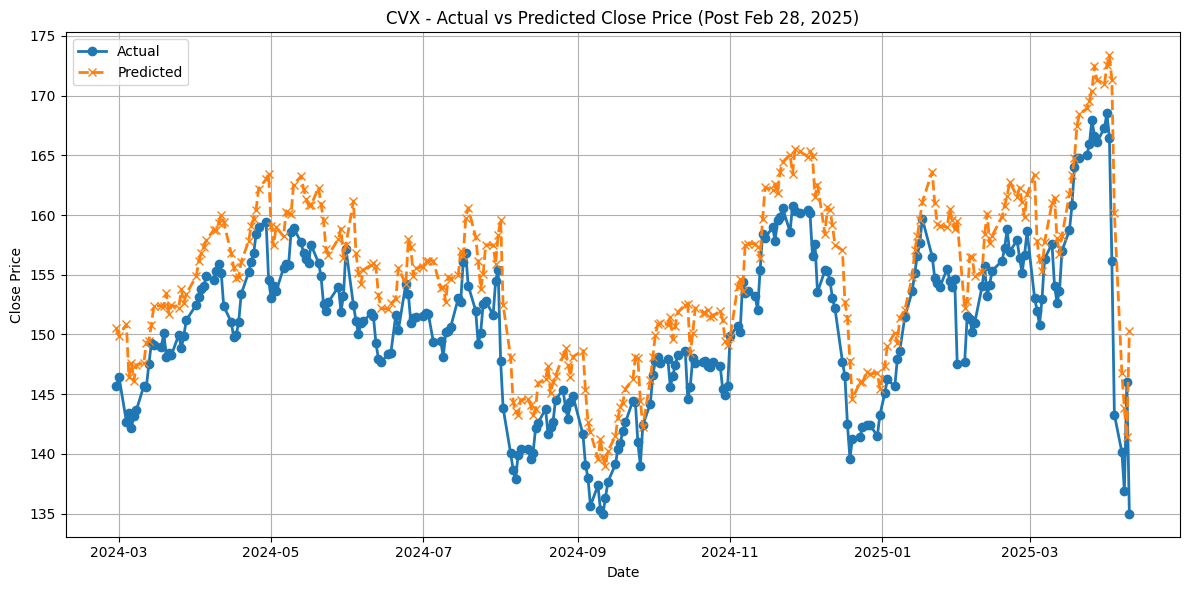

CVX - MAE: 4.28, RMSE: 4.85


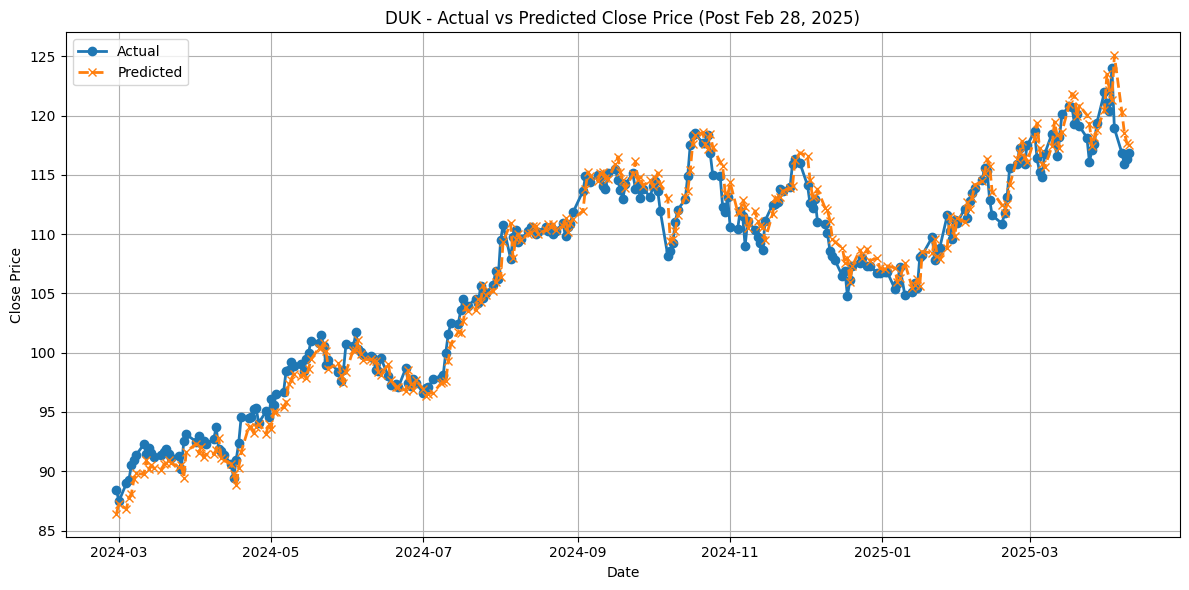

DUK - MAE: 1.14, RMSE: 1.46


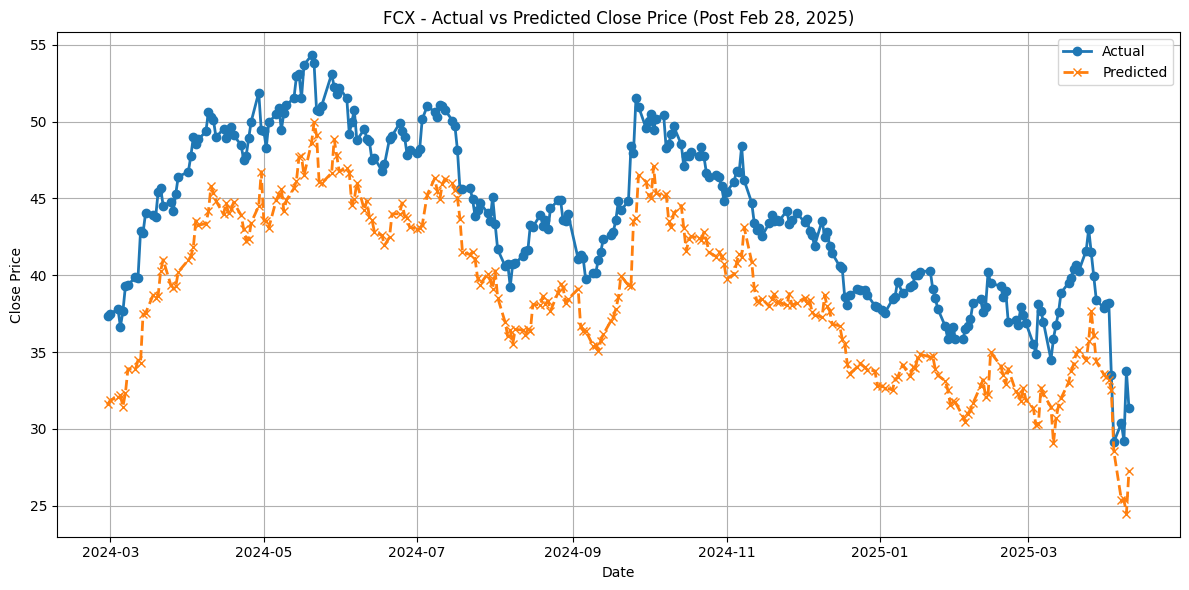

FCX - MAE: 5.07, RMSE: 5.21


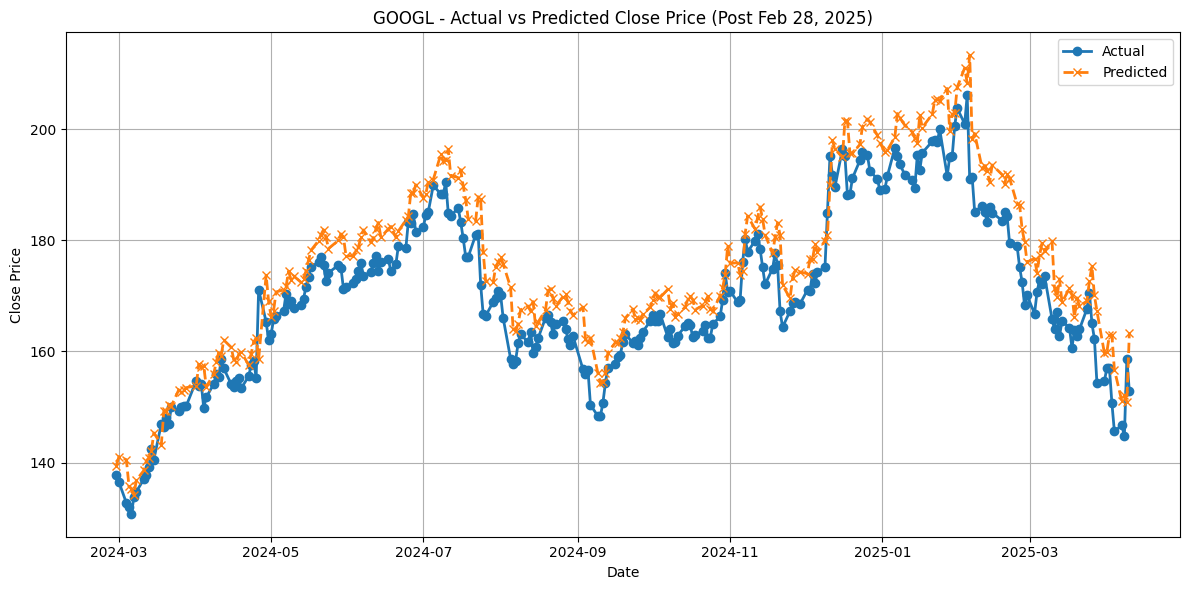

GOOGL - MAE: 5.58, RMSE: 6.41


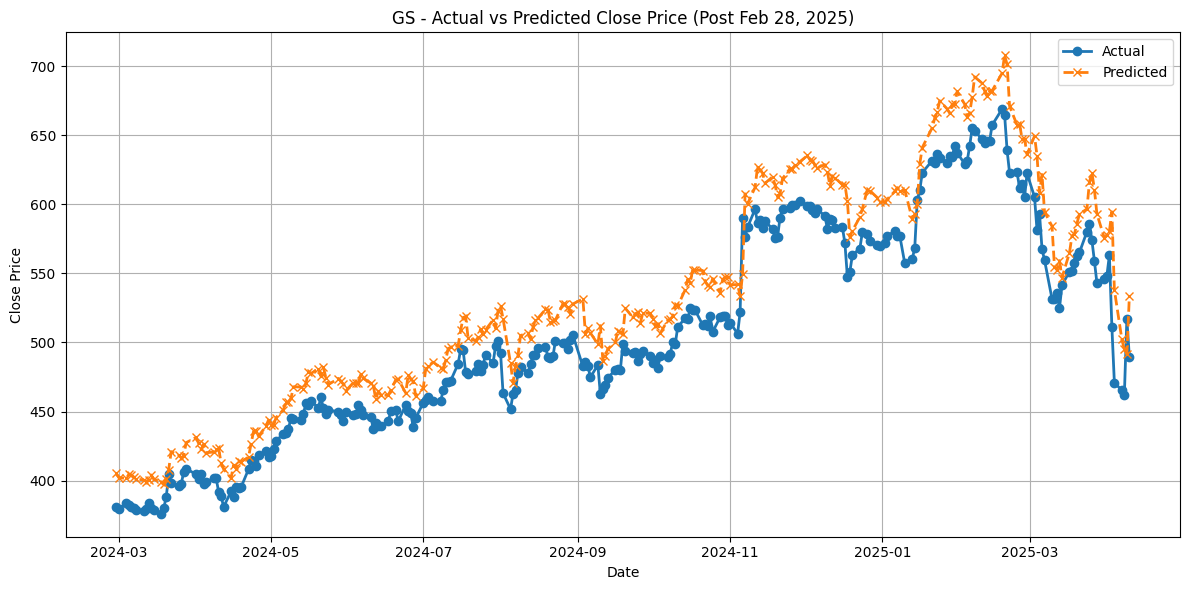

GS - MAE: 26.79, RMSE: 28.87


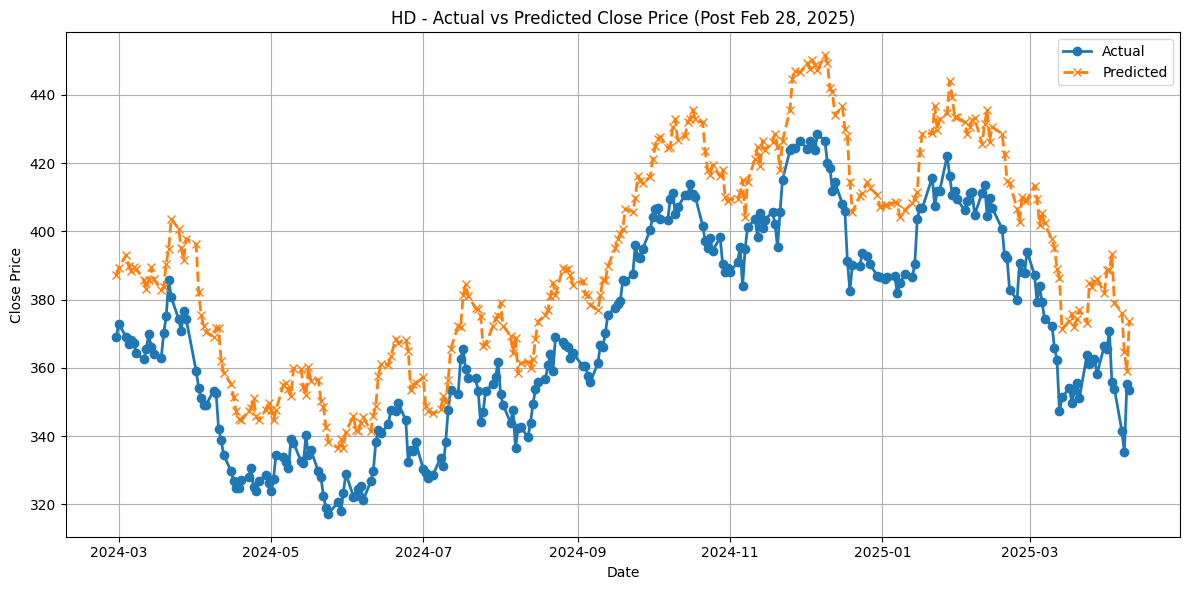

HD - MAE: 20.98, RMSE: 21.70


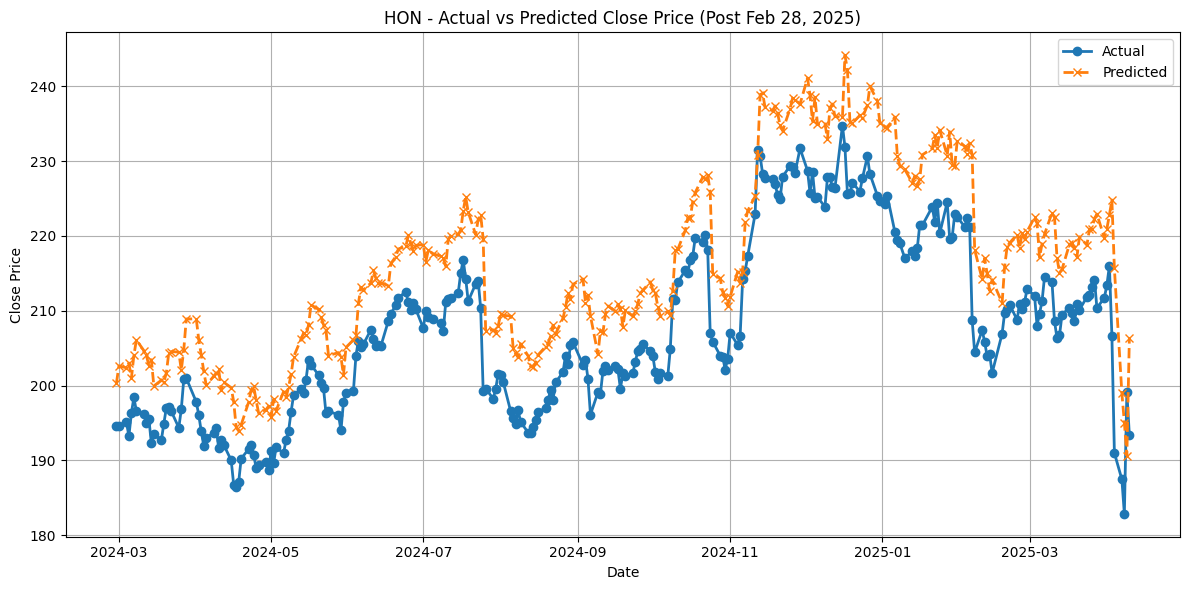

HON - MAE: 8.53, RMSE: 9.03


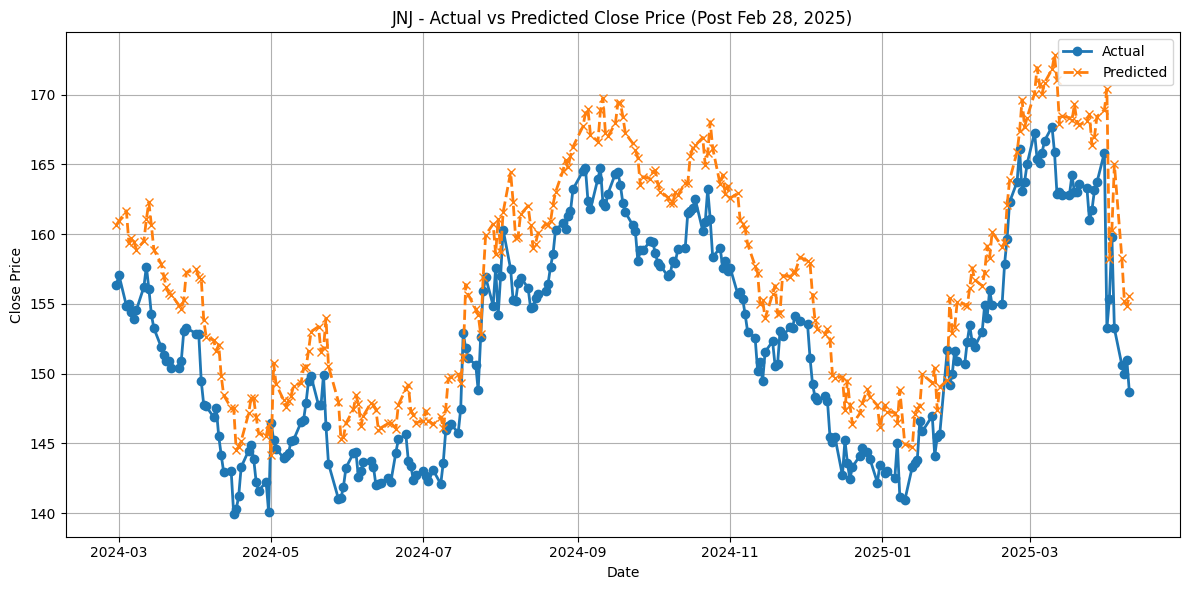

JNJ - MAE: 4.46, RMSE: 4.80


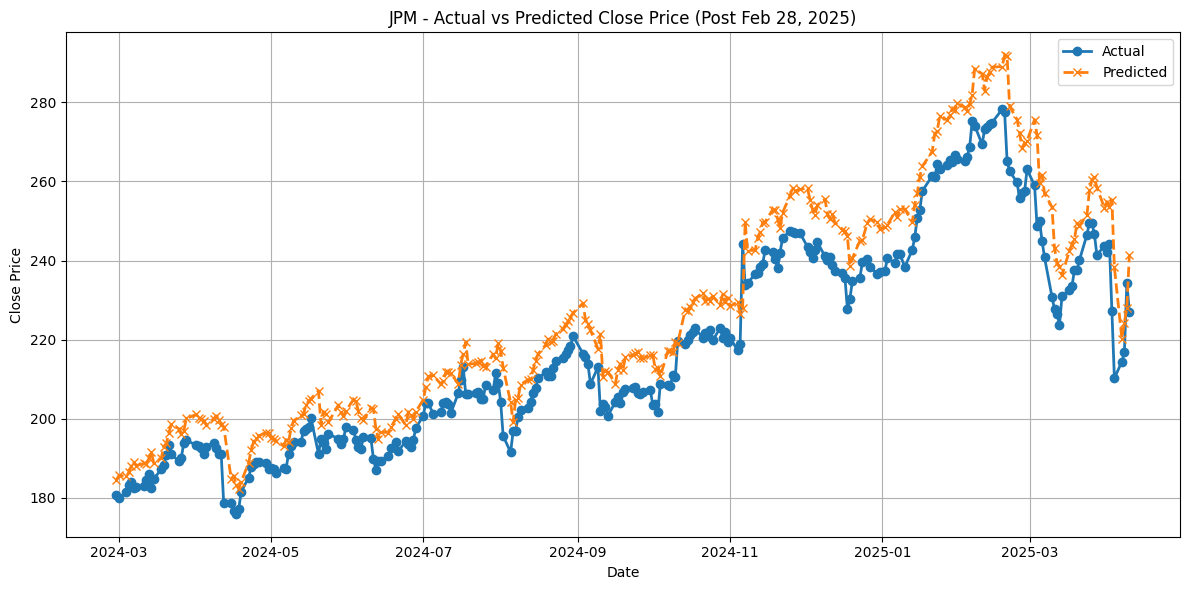

JPM - MAE: 8.97, RMSE: 9.91


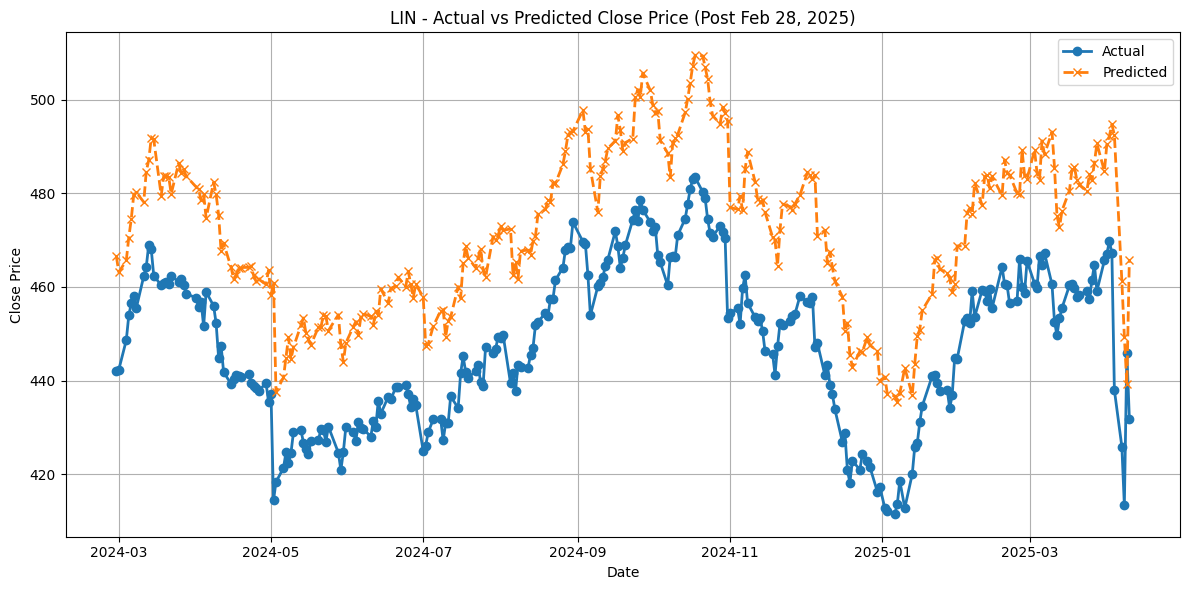

LIN - MAE: 24.01, RMSE: 24.51


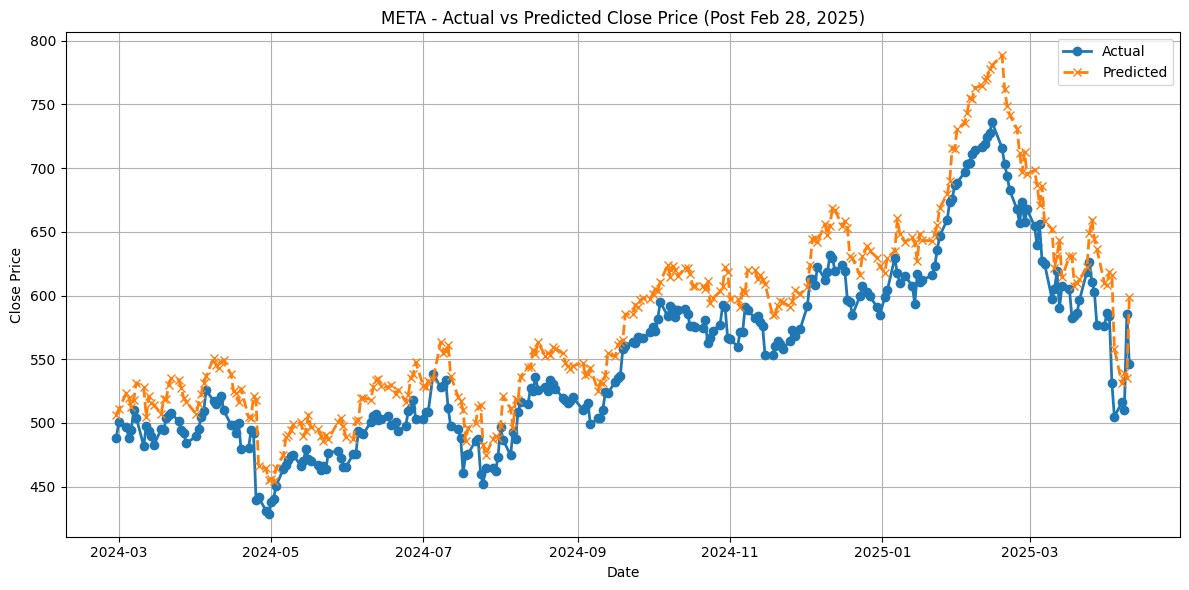

META - MAE: 29.61, RMSE: 32.42


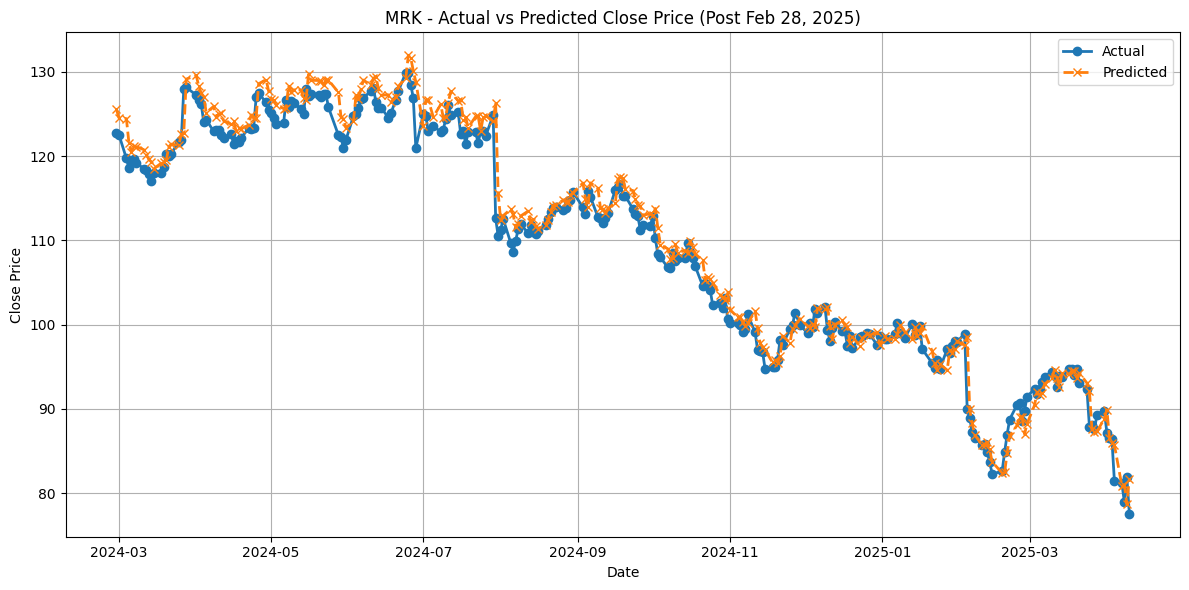

MRK - MAE: 1.58, RMSE: 2.11


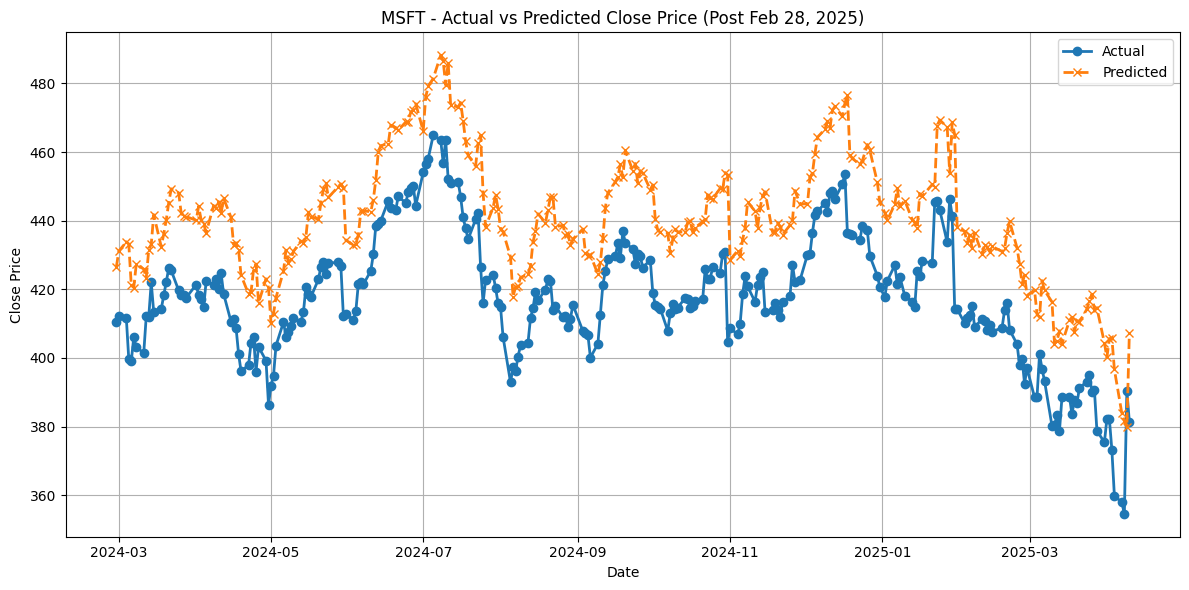

MSFT - MAE: 22.79, RMSE: 23.54


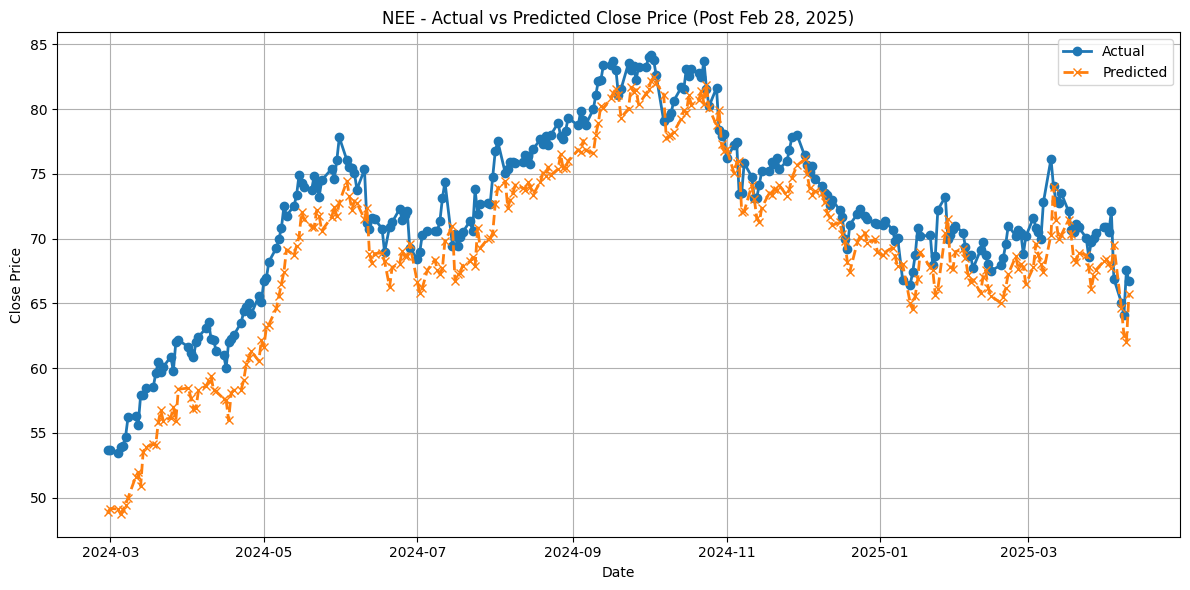

NEE - MAE: 2.71, RMSE: 3.05


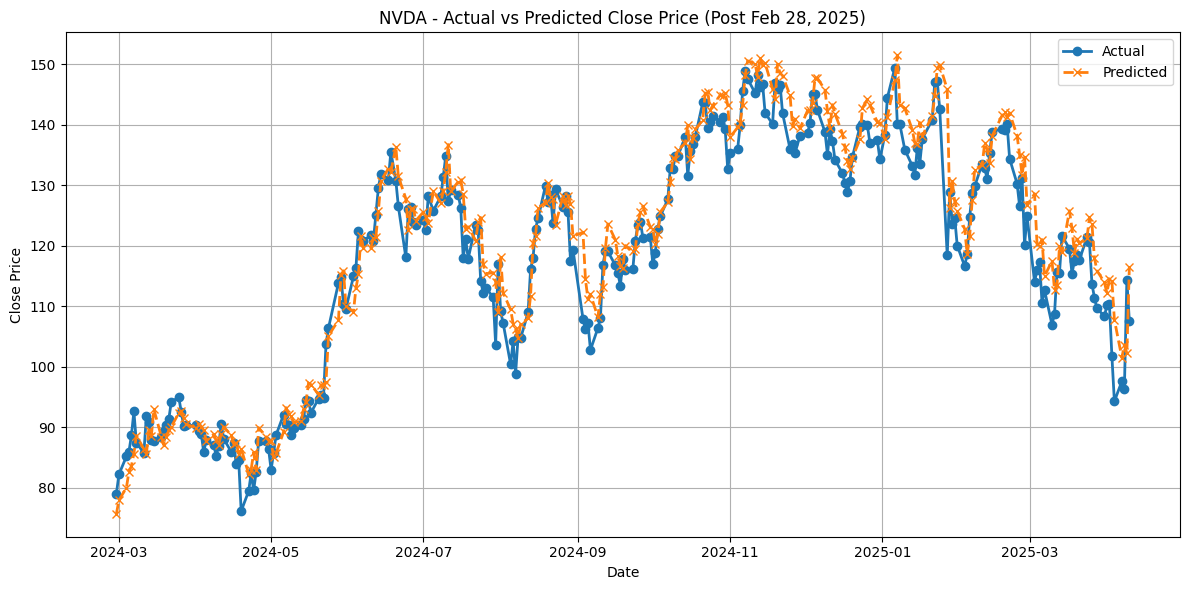

NVDA - MAE: 3.76, RMSE: 5.02


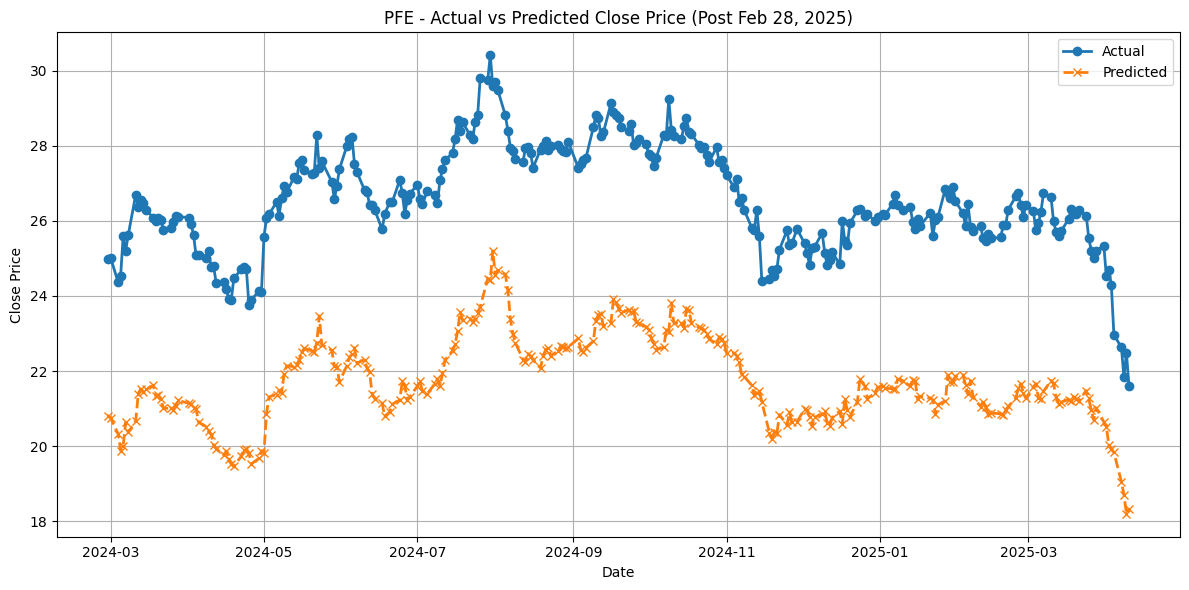

PFE - MAE: 4.82, RMSE: 4.85


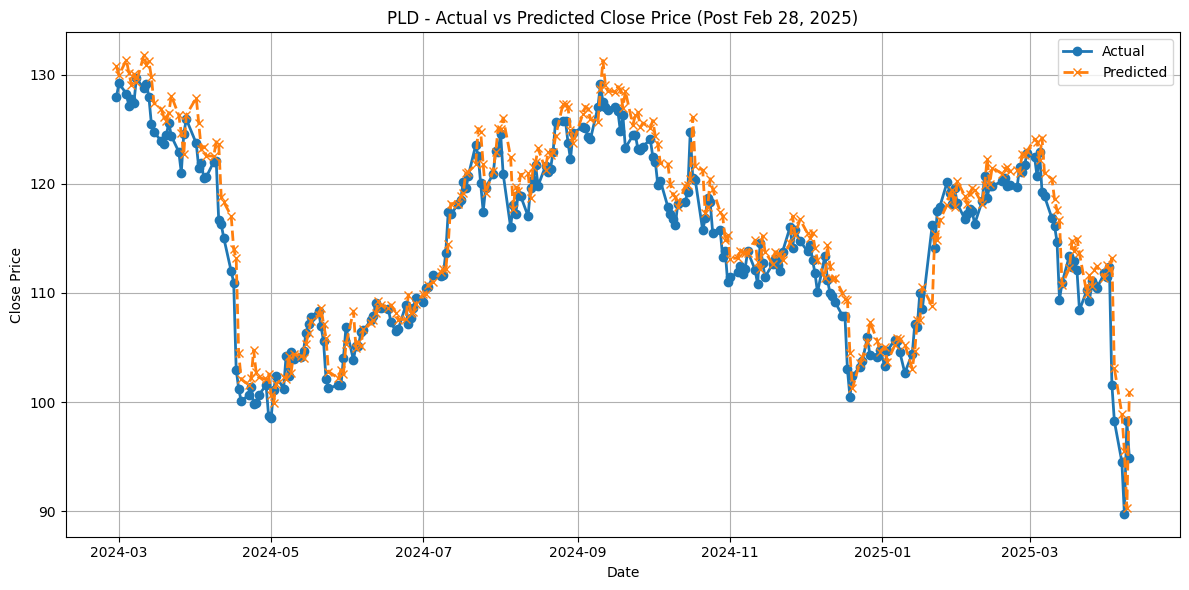

PLD - MAE: 2.01, RMSE: 2.63


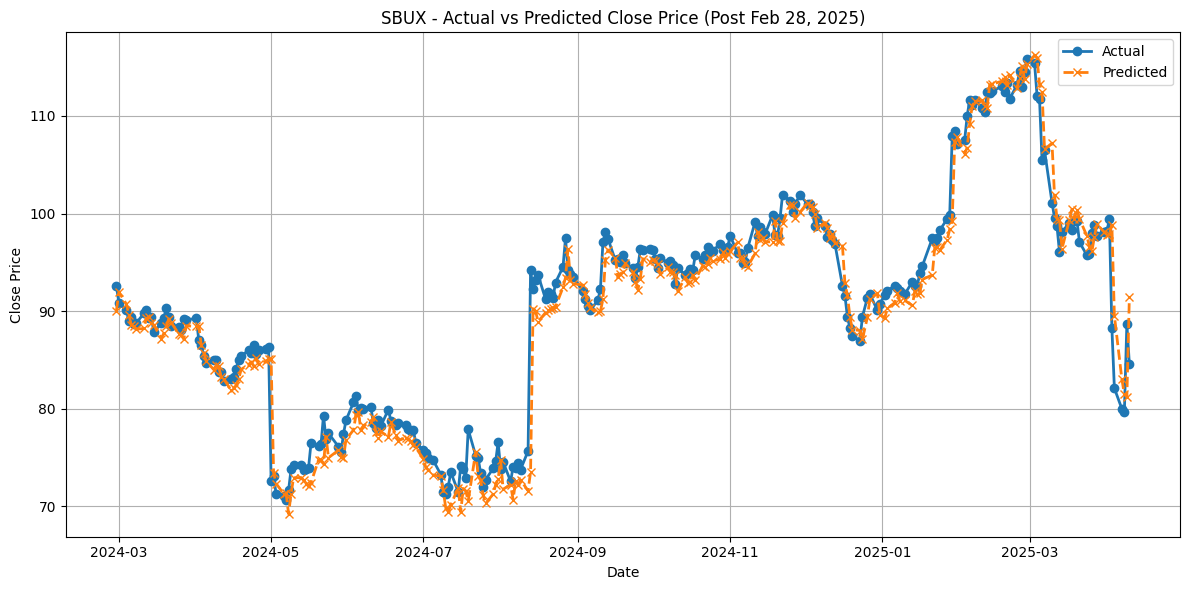

SBUX - MAE: 1.64, RMSE: 2.56


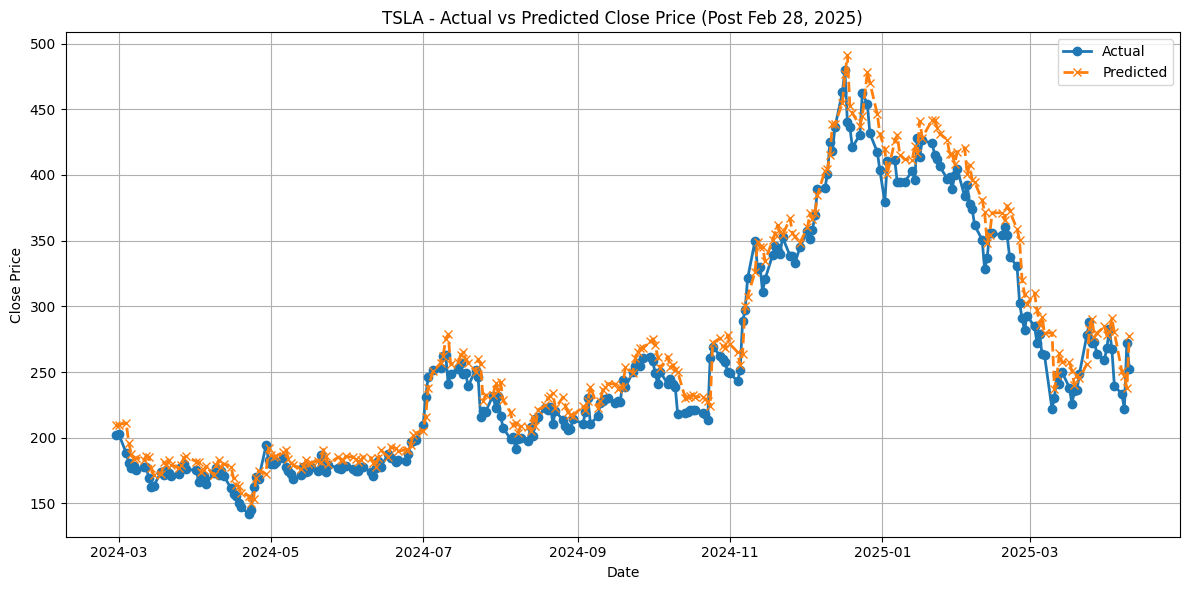

TSLA - MAE: 13.31, RMSE: 16.78


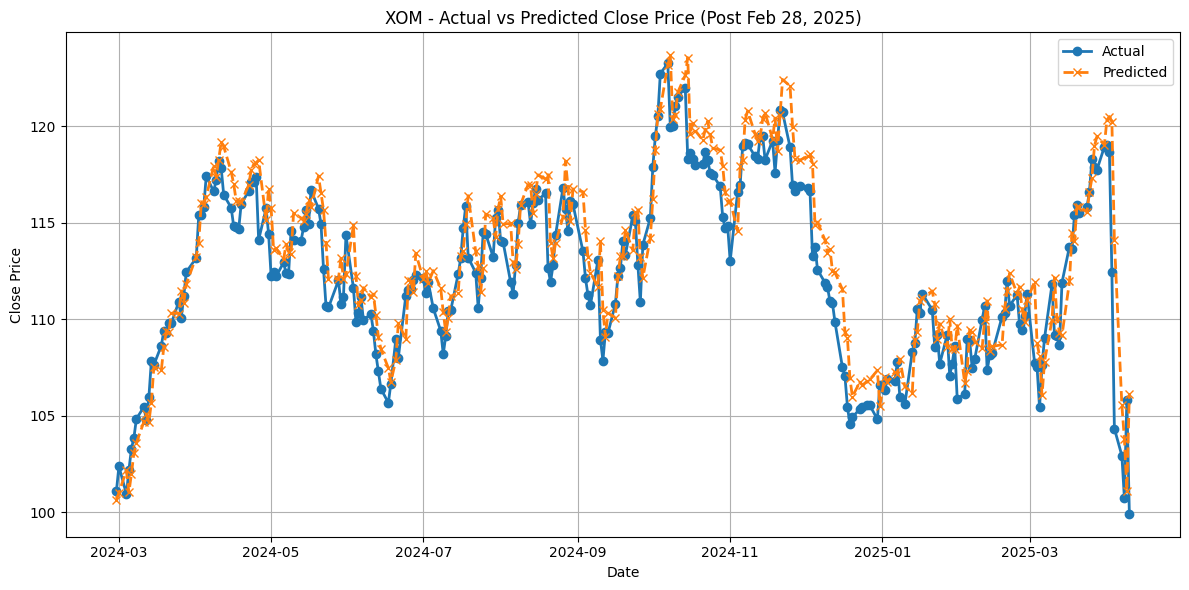

XOM - MAE: 1.46, RMSE: 1.92


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# First, make sure your ticker_list is in a numpy array so that you can apply the same mask:
ticker_array = np.array(ticker_list)

# Filter the ticker list using the mask for new data; this gives the ticker for each test sequence.
ticker_new = ticker_array[mask_new]

# Build a DataFrame with Date, Ticker, Actual, and Predicted values for the new test data.
df_results = pd.DataFrame({
    "Date": dates_new,
    "Ticker": ticker_new,
    "Actual": y_new,
    "Predicted": y_new_pred
})

# Ensure the Date column is in proper datetime format for plotting.
df_results["Date"] = pd.to_datetime(df_results["Date"])

# Sort the DataFrame by Ticker and Date
df_results = df_results.sort_values(by=["Ticker", "Date"])

# Get unique tickers available in your new test data.
unique_tickers = df_results["Ticker"].unique()

# Plot Actual vs Predicted Close Prices for each stock
for ticker in unique_tickers:
    # Filter data for the current ticker.
    df_ticker = df_results[df_results["Ticker"] == ticker].sort_values("Date")
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_ticker["Date"], df_ticker["Actual"], label="Actual", marker="o", linewidth=2)
    plt.plot(df_ticker["Date"], df_ticker["Predicted"], label="Predicted", linestyle="--", marker="x", linewidth=2)
    plt.title(f"{ticker} - Actual vs Predicted Close Price (Post Feb 28, 2025)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Optionally, compute and print error metrics for each ticker.
    mae = mean_absolute_error(df_ticker["Actual"], df_ticker["Predicted"])
    rmse = np.sqrt(mean_squared_error(df_ticker["Actual"], df_ticker["Predicted"]))
    print(f"{ticker} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load AAPL CSV
file_to_visualize = "./filtered_data_lstmgru2/AAPL.csv"
try:
    df = pd.read_csv(file_to_visualize)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.sort_values("Date", inplace=True)
    ticker_name = "AAPL"
except FileNotFoundError:
    print("AAPL.csv file not found in the ./filtered_data_lstmgru2 directory.")
    raise

# ===== Visualization 1: Enhanced Correlation Heatmap =====

# Compute correlation for all numerical features
numeric_cols = df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(80, 80))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Enhanced Correlation Heatmap for AAPL Numerical Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()






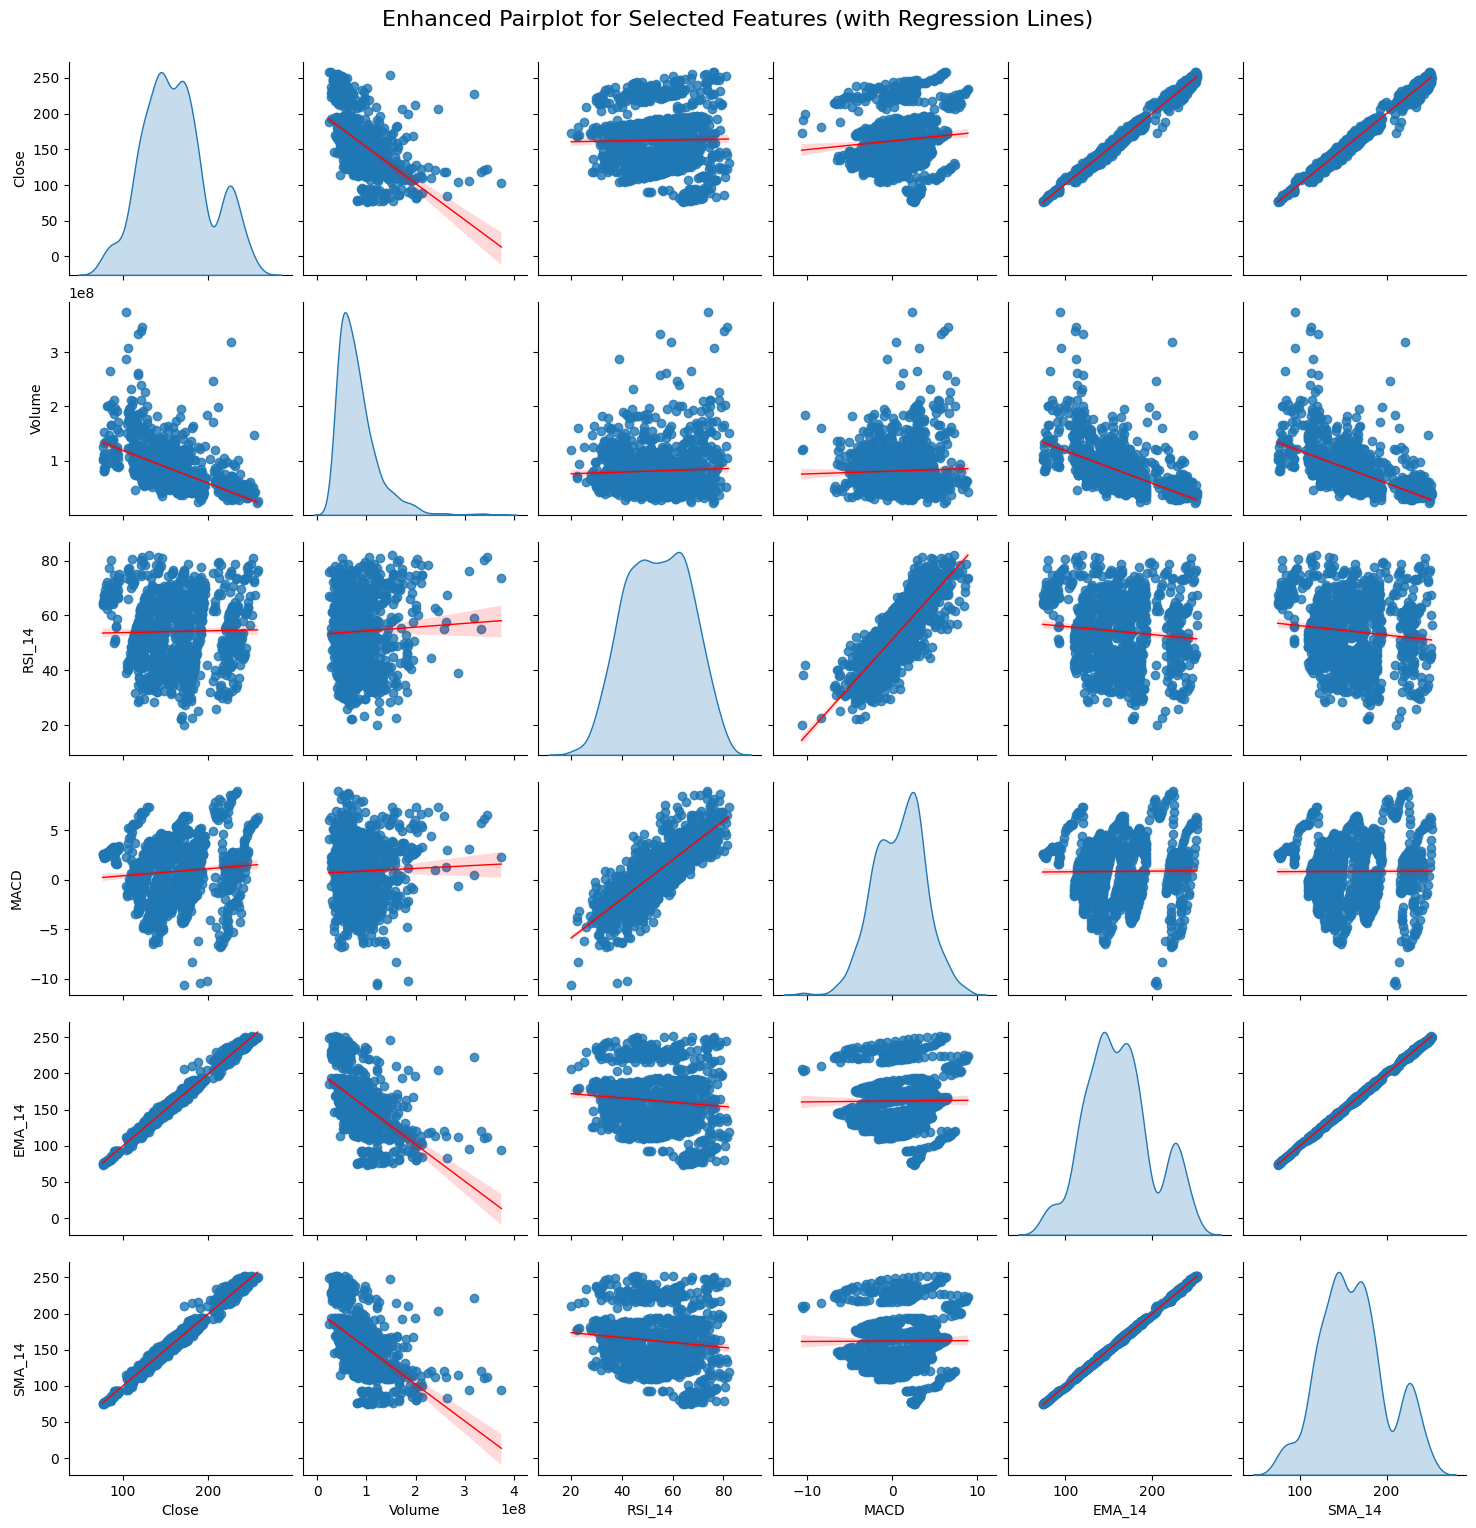

In [16]:
# ===== Visualization 2: Improved Pairplot for Selected Features =====

# Select a subset of features for analysis
selected_features = ["Close", "Volume", "RSI_14", "MACD", "EMA_14", "SMA_14"]
if set(selected_features).issubset(df.columns):
    sns.pairplot(df[selected_features], kind="reg", diag_kind="kde",
                 plot_kws={"line_kws": {"color": "red", "lw": 1}})
    plt.suptitle("Enhanced Pairplot for Selected Features (with Regression Lines)", 
                 y=1.02, fontsize=16)
    plt.show()
else:
    print("Some of the selected features are not present in the AAPL dataset.")



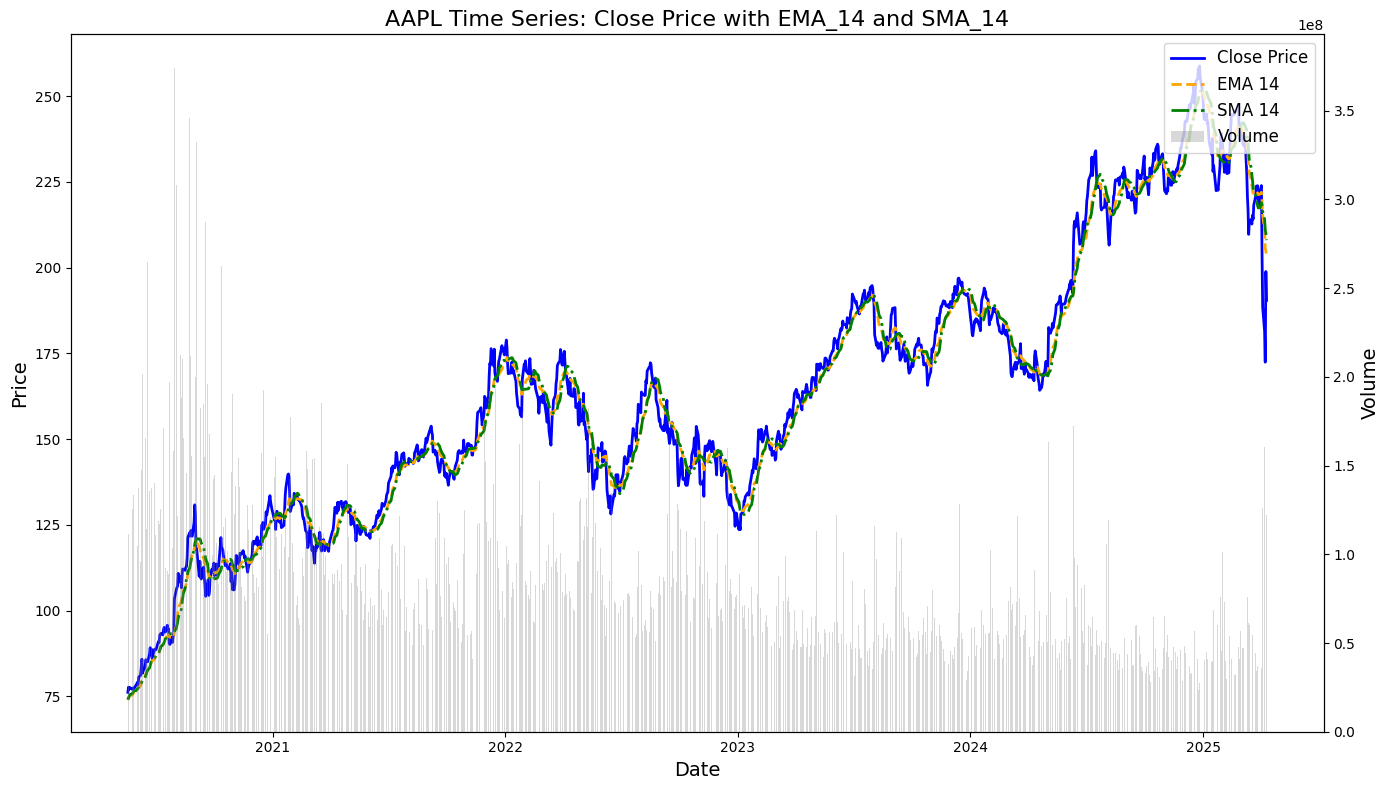

In [17]:
# ===== Visualization 3: Time Series and Trend Analysis =====

fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(df["Date"], df["Close"], label="Close Price", color="blue", linewidth=2)
if "EMA_14" in df.columns:
    ax1.plot(df["Date"], df["EMA_14"], label="EMA 14", color="orange", linestyle="--", linewidth=2)
if "SMA_14" in df.columns:
    ax1.plot(df["Date"], df["SMA_14"], label="SMA 14", color="green", linestyle="-.", linewidth=2)
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("Price", fontsize=14)
ax1.legend(loc="upper left")
ax1.set_title("AAPL Time Series: Close Price with EMA_14 and SMA_14", fontsize=16)

# Secondary axis for Volume
ax2 = ax1.twinx()
if "Volume" in df.columns:
    ax2.bar(df["Date"], df["Volume"], alpha=0.3, label="Volume", color="grey")
    ax2.set_ylabel("Volume", fontsize=14)
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()

# ===== Visualization 4: Enhanced Residual Analysis on Model Predictions =====

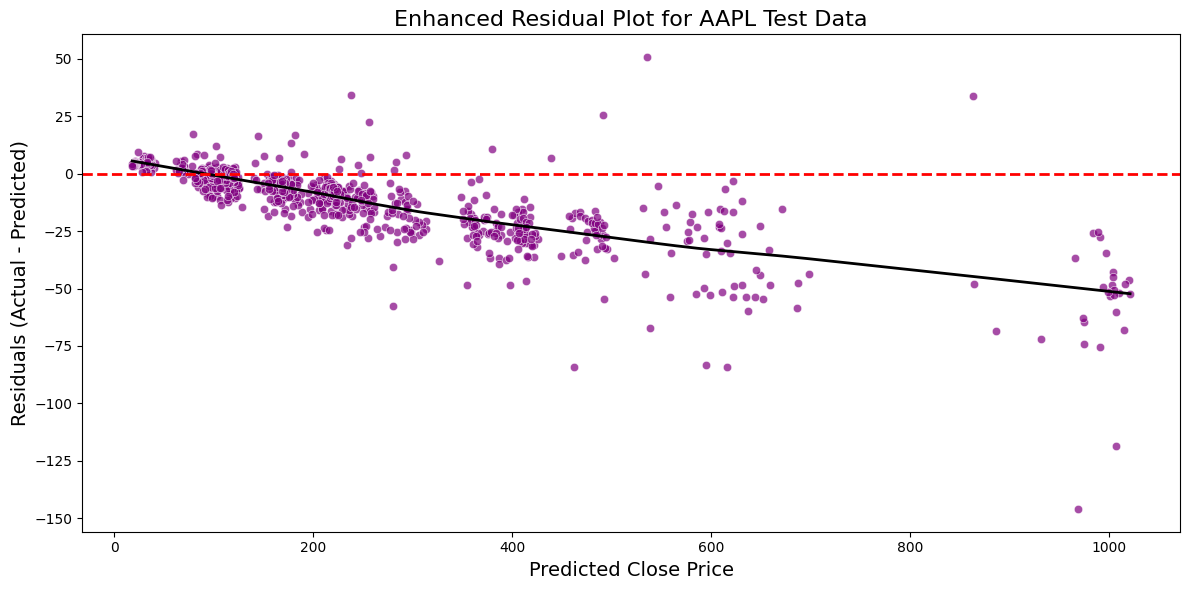

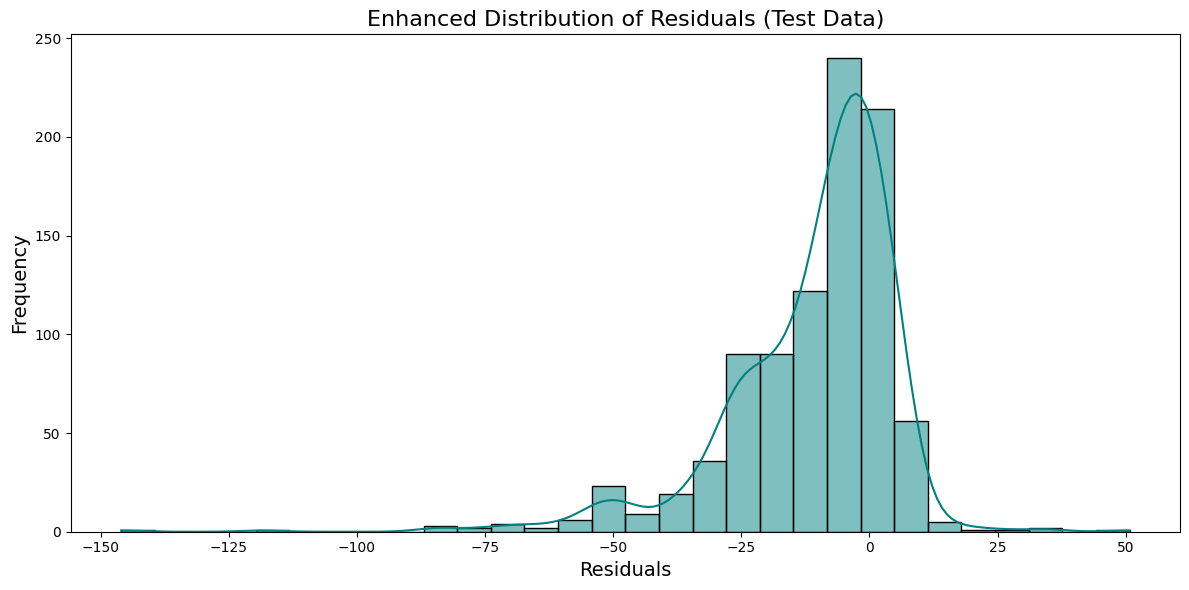

In [18]:
# ----- Visualization 4: Enhanced Residual Analysis on Model Predictions (Test Data) -----
# This section assumes that your model predictions and actual values for test data 
# have been computed as y_new_pred and y_new respectively.
if 'y_new' in globals() and 'y_new_pred' in globals():
    residuals = y_new - y_new_pred

    # Check if statsmodels is installed to enable LOWESS regression in regplot
    try:
        import statsmodels.api as sm  # Required for lowess functionality
        lowess_enabled = True
    except ImportError:
        print("Statsmodels not installed. LOWESS regression will be disabled.")
        lowess_enabled = False

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y_new_pred, y=residuals, alpha=0.7, color="purple")
    sns.regplot(x=y_new_pred, y=residuals, scatter=False, lowess=lowess_enabled,
                line_kws={"color": "black", "lw": 2})
    plt.axhline(0, color="red", linestyle="--", lw=2)
    plt.xlabel("Predicted Close Price", fontsize=14)
    plt.ylabel("Residuals (Actual - Predicted)", fontsize=14)
    plt.title("Enhanced Residual Plot for AAPL Test Data", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Histogram of residuals with KDE for distribution analysis
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, bins=30, color="teal")
    plt.xlabel("Residuals", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title("Enhanced Distribution of Residuals (Test Data)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("Model predictions (y_new_pred) and/or actual values (y_new) are not defined in the global namespace.")


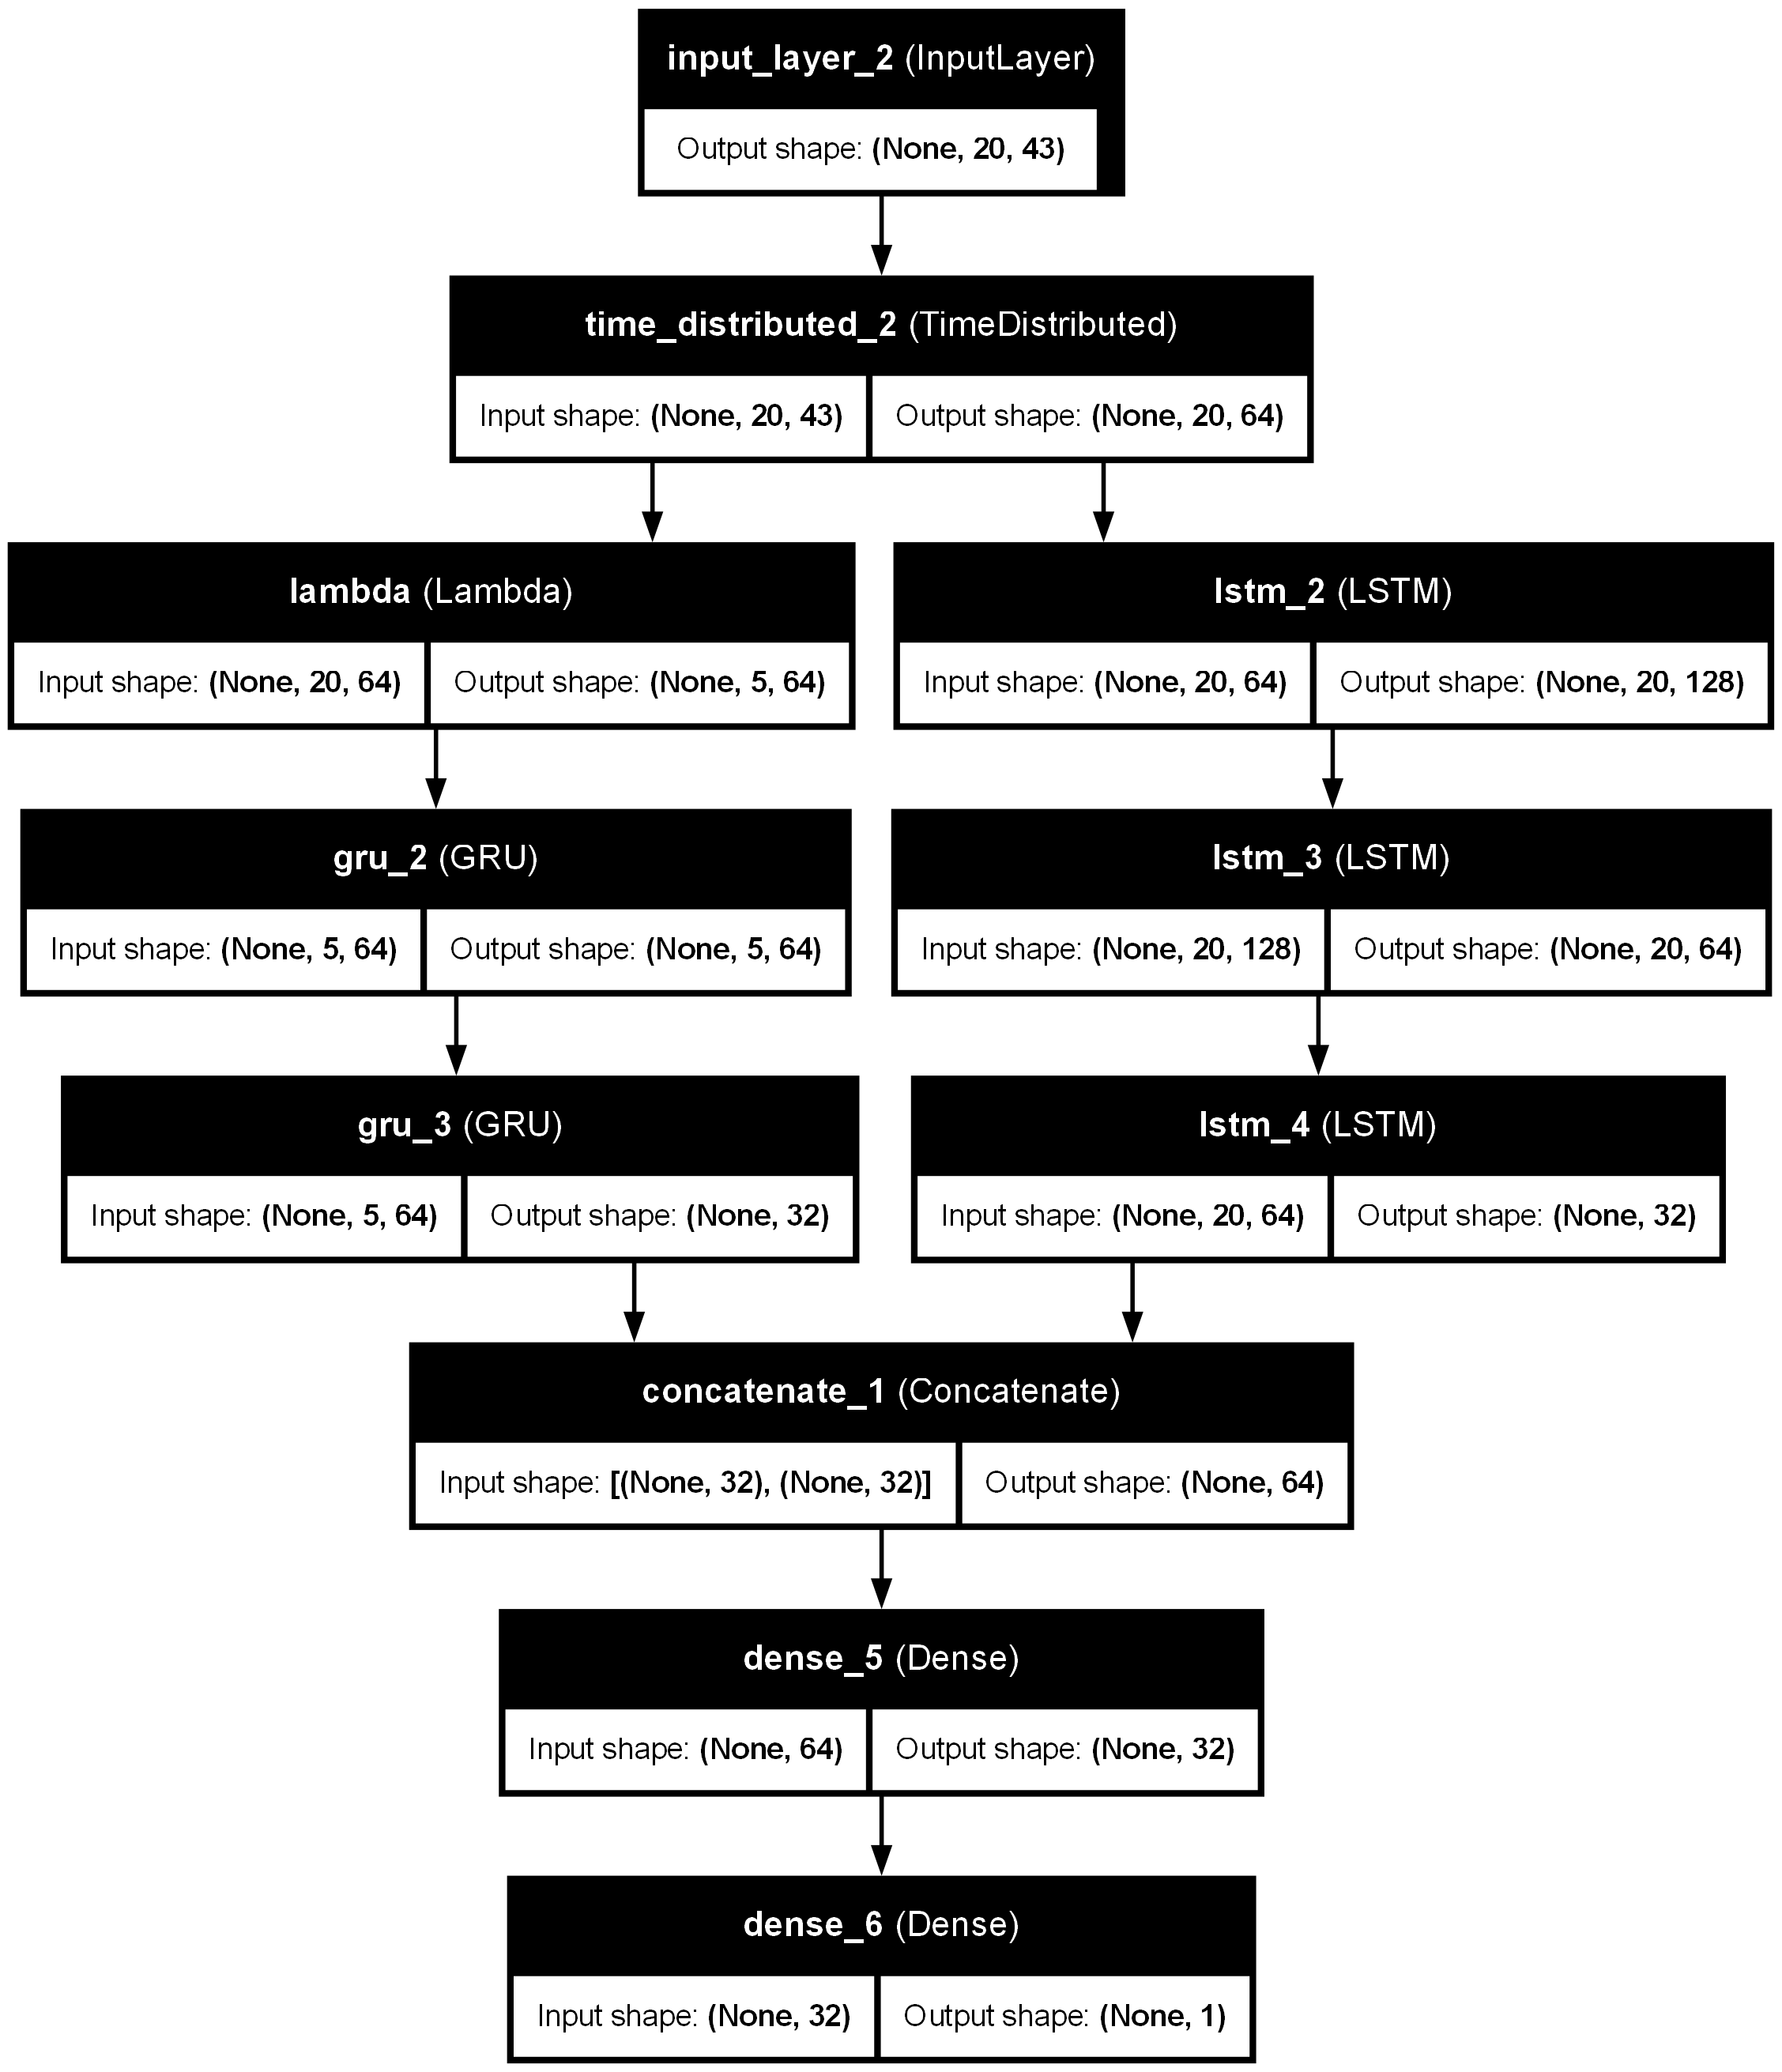

In [19]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
# Load your model
tf.keras.config.enable_unsafe_deserialization()
model = load_model("trained_model_lstmgru.keras")

# Plot and save the model architecture as an image
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0
